In [2]:
# Installation of library for confusion matrix
!pip install pytorch-ignite

  Using cached pytorch_ignite-0.4.4-py3-none-any.whl (200 kB)


In [1]:
import os
import datetime 
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from ignite.utils import to_onehot
from ignite.metrics import Precision, Recall, MetricsLambda, ConfusionMatrix
from torch.utils.data import Dataset, DataLoader

In [2]:
# Directories for main folder

# root_path = "dataset/"
root_path = "lung_dataset/"

val_normal = root_path + "test/normal"
val_infected_covid = root_path+"test/infected/covid"
val_infected_noncovid = root_path+"test/infected/non-covid"

train_normal = root_path + "train/normal"
train_infected_covid = root_path+"train/infected/covid"
train_infected_noncovid = root_path+"train/infected/non-covid"

test_normal = root_path + "val/normal"
test_infected_covid = root_path+"val/infected/covid"
test_infected_noncovid = root_path+"val/infected/non-covid"

# Labels
labels_dict = {0: "normal", 1: "infected"}
labels_dict_infected = {0: "non-covid", 1: "covid"}
labels_dict_test = {0:'normal', 1:'infected', 2:'non-covid', 3:'covid'}

# Helper function to count items in directory
def count_from_dir(path):
    return len(os.listdir(path))

## Creating a Dataset object

In [3]:
# Dataset object for training and validation
class Lung_Dataset(Dataset):
    def __init__(self, label, group, dataset_paths):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """

        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected) or (covid and non-covid)
        self.classes = label
        
        # The dataset consists only of test images
        self.group = group

        # Path to images for different parts of the dataset
        self.dataset_paths = dataset_paths
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {}
        for key, listofpaths in dataset_paths.items(): # e.g. {'train_normal': [train_normal],  'train_infected': [train_infected_covid, train_infected_noncovid]}
            for path in listofpaths:
                num = count_from_dir(path)
                if key not in self.dataset_numbers:
                    self.dataset_numbers[key] = {path: num}
                else:
                    olddict = self.dataset_numbers[key]
                    olddict[path] = num
                    self.dataset_numbers[key] = olddict
    

    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """

        # Generate description
        msg = "This is the {} dataset of the Lung Dataset".format(self.group)
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        for key, listofpaths in self.dataset_paths.items():
            length = 0
            for path in listofpaths:
                length += self.dataset_numbers[key][path]
            msg += "- {} has a total of {} images.\n".format(key, length)
        print(msg)
    

    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.group, err_msg
        
        err_msg = "Error - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid')."
        assert class_val in self.classes.values(), err_msg
        
        max_val = sum(self.dataset_numbers['{}_{}'.format(group_val, class_val)].values())
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images-1."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        for path in self.dataset_paths['{}_{}'.format(group_val, class_val)]:
            length = self.dataset_numbers['{}_{}'.format(group_val, class_val)][path]
            if index_val >= length: 
                index_val -= length
                continue
            else: 
                path_to_file = '{}/{}.jpg'.format(path, index_val)
                with open(path_to_file, 'rb') as f:
                    im = np.asarray(Image.open(f))/255
                f.close()
                return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """

        # Open and display image
        im = self.open_img(group_val, class_val, index_val)
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        total = 0
        for key, val in self.dataset_numbers.items():
            for num in val.values():
                total += num
        return total
    

    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """

        # Get length of each class
        itemtotal = {}
        for key, val in self.classes.items(): # e.g. {0: 'normal', 1: 'infected'}
            itemtotal[key] = sum(self.dataset_numbers['{}_{}'.format(self.group, val)].values())

        # Get item special method
        first_val = itemtotal[0]
        if index < first_val:
            class_val = self.classes[0]
            label = torch.Tensor([1, 0])
        else:
            class_val = self.classes[1]
            index = index - first_val
            label = torch.Tensor([0, 1])
        im = self.open_img(self.group, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [4]:
# Dataset object for test set
class Test_Lung_Dataset(Dataset):
    def __init__(self, label, group, dataset_paths):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """

        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected) or (covid and non-covid)
        self.classes = label
        
        # The dataset consists only of test images
        self.group = group

        # Path to images for different parts of the dataset
        self.dataset_paths = dataset_paths
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {}
        for key, listofpaths in dataset_paths.items(): # e.g. {'train_normal': [train_normal],  'train_infected': [train_infected_covid, train_infected_noncovid]}
            for path in listofpaths:
                num = count_from_dir(path)
                if key not in self.dataset_numbers:
                    self.dataset_numbers[key] = {path: num}
                else:
                    olddict = self.dataset_numbers[key]
                    olddict[path] = num
                    self.dataset_numbers[key] = olddict

    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """

        # Generate description
        msg = "This is the {} dataset of the Lung Dataset".format(self.group)
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        for key, listofpaths in self.dataset_paths.items():
            length = 0
            for path in listofpaths:
                length += self.dataset_numbers[key][path]
            msg += "- {} has a total of {} images.\n".format(key, length)
        print(msg)
    

    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.group, err_msg
        
        err_msg = "Error - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid')."
        assert class_val in self.classes.values(), err_msg
        
        max_val = sum(self.dataset_numbers['{}_{}'.format(group_val, class_val)].values())
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images-1."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        for path in self.dataset_paths['{}_{}'.format(group_val, class_val)]:
            length = self.dataset_numbers['{}_{}'.format(group_val, class_val)][path]
            if index_val >= length: 
                index_val -= length
                continue
            else: 
                path_to_file = '{}/{}.jpg'.format(path, index_val)
                with open(path_to_file, 'rb') as f:
                    im = np.asarray(Image.open(f))/255
                f.close()
                return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """

        # Open and display image
        im = self.open_img(group_val, class_val, index_val)
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        total = 0
        for key, val in self.dataset_numbers.items():
            for num in val.values():
                total += num
        return total
    

    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """

        # Get length of each class
        itemtotal = {}
        for key, val in self.classes.items(): # e.g. {0:'normal', 1:'infected', 2:'non-covid', 3:'covid'}
            if(key == 0 or key == 1):
                itemtotal[key] = sum(self.dataset_numbers['{}_{}'.format(self.group, val)].values())
            elif (key == 2):
                key2 = list(self.dataset_numbers['test_infected'].values())
                itemtotal[key] = key2[0]
            elif (key == 3):
                key2 = list(self.dataset_numbers['test_infected'].values())
                itemtotal[key] = key2[1]
        
        # Get item special method
        first_val = itemtotal[0]
        non_covid = itemtotal[2]
        
        # One Hot Encoding
        
        # Normal will be [1,0,0,0]
        if index < first_val:
            class_val = self.classes[0]
            label = torch.Tensor([1, 0,0,0])
        else:
            index = index - first_val
            # Infected Non-covid will be [0,1,1,0]
            if index < non_covid:
                class_val = self.classes[1]
                label = torch.Tensor([0, 1,1,0])
            else:
                # Infected Covid will be [0,1,0,1]
                class_val = self.classes[1]
                label = torch.Tensor([0, 1,0,1])
            
        im = self.open_img(self.group, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [5]:
# 1st Classifier
print("1st Classifier")
print("\nTraining Dataset")
ld_train = Lung_Dataset(labels_dict, "train", {"train_normal": [train_normal],  "train_infected": [train_infected_covid, train_infected_noncovid]})
ld_train.describe()

print("\nVal Dataset")
ld_val = Lung_Dataset(labels_dict, "val", {"val_normal": [val_normal],  "val_infected": [val_infected_covid, val_infected_noncovid]})
ld_val.describe()

# 2nd Classifier
print("\n2nd Classifier")
print("\nTraining Dataset")
ld_train2 = Lung_Dataset(labels_dict_infected, "train", {"train_non-covid": [train_infected_noncovid],  "train_covid": [train_infected_covid]})
ld_train2.describe()

print("\nVal Dataset")
ld_val2 = Lung_Dataset(labels_dict_infected, "val", {"val_non-covid": [val_infected_noncovid],  "val_covid": [val_infected_covid]})
ld_val2.describe()

# Test Classifier
print("\nTesting")
print("\nTest Dataset")
ld_test = Test_Lung_Dataset(labels_dict_test, "test", {"test_normal": [test_normal],  "test_infected": [test_infected_covid, test_infected_noncovid]})
ld_test.describe()

1st Classifier

Training Dataset
This is the train dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- train_normal has a total of 1341 images.
- train_infected has a total of 3875 images.


Val Dataset
This is the val dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- val_normal has a total of 234 images.
- val_infected has a total of 381 images.


2nd Classifier

Training Dataset
This is the train dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- train_non-covid has a total of 2530 images.
- train_covid has a total of 1345 images.


Val Dataset
This is the val dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- val_non-covid has a total of 242 images.
- val_covid has a total of 139 images.


Testing

Test Dataset
This is the test

# DataLoader

## Plotting the distribution data

In [7]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar to display its height.
    """

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

### Bar graph (Normal and Infected)

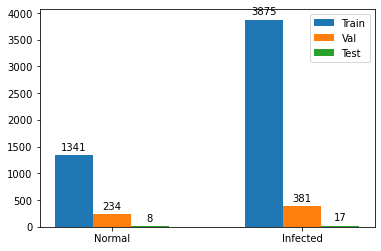

In [8]:
# Initialize labels and and number of data in train/val/test
labels2 = ['Normal','Infected']
train2 = [count_from_dir(train_normal), count_from_dir(train_infected_covid)+count_from_dir(train_infected_noncovid)] # [1341,3875]
val2 = [count_from_dir(val_normal), count_from_dir(val_infected_covid)+count_from_dir(val_infected_noncovid)] # [8,17]
test2 = [count_from_dir(test_normal), count_from_dir(test_infected_covid)+count_from_dir(test_infected_noncovid)] # [234,381]

# Set width of the bars and label locations
width2 = 0.2
x2 = np.arange(len(labels2))

# Plot and label the bar graph
fig2, ax2 = plt.subplots()
rects1 = ax2.bar(x2 - width2, train2, width2, label='Train')
rects2 = ax2.bar(x2, val2, width2, label='Val')
rects3 = ax2.bar(x2 + width2, test2, width2, label='Test')
autolabel(rects1,ax2)
autolabel(rects2,ax2)
autolabel(rects3,ax2)
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2)
ax2.legend()
plt.show()

### Bar graph (Covid and Non-Covid)

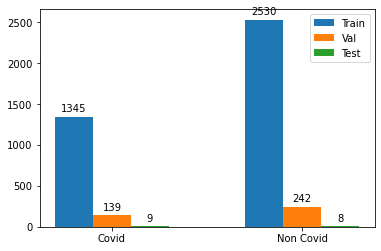

In [9]:
# Initialize labels and and number of data in train/val/test
labels3 = ['Covid','Non Covid']
train3 = [count_from_dir(train_infected_covid), count_from_dir(train_infected_noncovid)] # [1345, 2530] 
val3 = [count_from_dir(val_infected_covid), count_from_dir(val_infected_noncovid)] # [9, 8]
test3 = [count_from_dir(test_infected_covid), count_from_dir(test_infected_noncovid)] # [139, 242]

# Set width of the bars and label locations
width3 = 0.2
x3 = np.arange(len(labels3))

# Plot and label the bar graph
fig3, ax3 = plt.subplots()
rects1 = ax3.bar(x3 - width3, train3, width3, label='Train')
rects2 = ax3.bar(x3, val3, width3, label='Val')
rects3 = ax3.bar(x3 + width3, test3, width3, label='Test')
autolabel(rects1,ax3)
autolabel(rects2,ax3)
autolabel(rects3,ax3)
ax3.set_xticks(x3)
ax3.set_xticklabels(labels3)
ax3.legend()
plt.show()

## Creating a Dataloader object

In [18]:
# Batch size value to be used
bs_val = 64

# Dataloader from dataset (train-1st Classifier)
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
print(train_loader)
print(len(train_loader))

# # Dataloader from dataset (test-1st Classifier)
# test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
# print(test_loader)

# Dataloader from dataset (val-1st Classifier)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

# Dataloader from dataset (train-2nd Classifier)
train_loader2 = DataLoader(ld_train2, batch_size = bs_val, shuffle = True)
print(train_loader2)
print(len(train_loader2))

# Dataloader from dataset (val-2nd Classifier)
val_loader2 = DataLoader(ld_val2, batch_size = bs_val, shuffle = True)
print(val_loader2)

# Dataloader from dataset (test), Set Batch Size to 1 for test only
test_loader = DataLoader(ld_test, batch_size = 1, shuffle = True)
print(test_loader)

82
61


# Model

In [7]:
### Inspired by DenseNet Architecture ###
class Net(nn.Module):
    def __init__(self, conv_layer, output_size):
        super(Net, self).__init__()
        
        dim = 150
        kernel_size = 3
        self.output_size = output_size
        
        self.conv1 = nn.ModuleList([])
        self.conv1.append(nn.Conv2d(1, 64, kernel_size=3, stride=2))
        self.conv1.append(nn.MaxPool2d(kernel_size=3, stride=2))
        
        self.cnn_layers = nn.ModuleList([])
        for i in range(len(conv_layer)-1):
            self.cnn_layers.append(nn.Conv2d(in_channels=conv_layer[i], out_channels=conv_layer[i+1], kernel_size=kernel_size))
            self.cnn_layers.append(nn.BatchNorm2d(conv_layer[i+1]))
            self.cnn_layers.append(nn.ReLU())
        
        self.output = nn.Linear(147968, output_size)

    def forward(self, x):
        for start in self.conv1:
            x = start(x)
        for layers in self.cnn_layers:
            x = layers(x)
        for layers in self.cnn_layers:
            y = layers(x)
        
        c = torch.cat((x, y), dim=1)
        x = nn.Flatten()(c)
        x = self.output(x)
        output = F.log_softmax(x, dim = 1)

        return output

In [8]:
# Initialize Model
OUTPUT_SIZE = 2
CONV_LAYERS = [64,64]

model = Net(CONV_LAYERS, OUTPUT_SIZE)
model

Net(
  (conv1): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output): Linear(in_features=147968, out_features=2, bias=True)
)

# Save and load model

In [9]:
# Define function to save checkpoint
def save_checkpoint(model, path):
    checkpoint = {'lr': model.lr,
                  'labelsdict': model.labels_dict,
                  'state_dict': model.state_dict(),
                  'optim_state_dict': model.optimizer_state_dict,
                  }
    torch.save(checkpoint, path)
    
# Define function to load model
def load_model(path):
    cp = torch.load(path)

    CONV_LAYERS = [64,64]
    OUTPUT_SIZE = 2
    
    # Make classifier
    model = Net(CONV_LAYERS, OUTPUT_SIZE)
    
    # Add model info 
    model.lr = cp['lr']
    model.labels_dict = cp['labelsdict']
    model.load_state_dict(cp['state_dict'])
    model.optimizer_state_dict = cp['optim_state_dict']
    
    return model

# Early Stopping

Adapted from https://github.com/Bjarten/early-stopping-pytorch

In [14]:
# Run this to install the library if first time running
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

fatal: destination path './earlystopping' already exists and is not an empty directory.


In [10]:
# import EarlyStopping
from earlystopping.pytorchtools import EarlyStopping

# Training Helper Functions

In [11]:
# Define function to plot the training/ validation loss
def learning_curve(train_scores, val_scores, epoch, text):
    plt.style.use('seaborn')
    plt.plot([i+1 for i in range(epoch)], train_scores, label = 'Training error')
    plt.plot([i+1 for i in range(epoch)], val_scores, label = 'Validation error')
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)
    plt.title(text, fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()


# Define function to train the model
def train(epoch, labels_dict, train_loader,valid_loader, model, lr, device, modelType,patience = 5):
    
    # Define criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model.to(device)
    running_loss = 0
    train_loss = []
    val_loss = []
    
    # Initialize the early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for i in tqdm(range(0,epoch)):
        model.train()
        for batch_idx, (images_data, target_labels) in enumerate(train_loader):
            images_data,target_labels = images_data.to(device), target_labels.to(device)

            optimizer.zero_grad()

            target_labels = target_labels.long()
            target_labels = torch.argmax(target_labels, dim=1)
            output = model.forward(images_data)
            loss = criterion(output, target_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Eval mode for predictions
        model.eval()

        # Turn off gradients for validation
        with torch.no_grad():
            test_loss, accuracy, F1_score, cm = validation_model(model, valid_loader, criterion, device)

        print("Epoch: {}/{} - ".format(i+1, epoch),
                "Time:{}".format(datetime.datetime.now()),
                    "Training Loss: {:.3f} - ".format(running_loss/batch_idx),
                         "Validation Loss: {:.3f} - ".format(test_loss/len(valid_loader)),
                            "Validation Accuracy: {:.3f} - ".format(accuracy/len(valid_loader)))
        print("F1 score: {:.3f}".format(F1_score),
                  "Confusion Matrix:", cm)
        
        train_loss.append(running_loss/batch_idx)
        val_loss.append(test_loss/len(valid_loader))
        running_loss = 0
        
        # Early stopping - early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(test_loss/len(valid_loader), model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Ensure training is turned back on
        model.train()
        
        # Add model info 
        model.lr = lr
        model.optimizer_state_dict = optimizer.state_dict
        model.labels_dict = labels_dict

        # Saving of epoch Model
        saveName = "group20-"+ modelType + "-epoch" + str(i) + ".pt"
        save_checkpoint(model,saveName)
    
    # Plot the training/ validation loss
    learning_curve(train_loss, val_loss, len(train_loss), "Model of {} vs {}".format(labels_dict[0],labels_dict[1]))
    
    # Loading the last checkpoint with the best model for Early stopping
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    # Add model info
    model.lr = lr
    model.optimizer_state_dict = optimizer.state_dict
    model.labels_dict = labels_dict
    
    # Saving final trained Model
    saveName = "group20-"+ modelType +"-final.pt"
    save_checkpoint(model,saveName)

    return model

# Evaluation Helper Functions

In [12]:
# Define validation function
def validation_model(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    
    # true_positives / (positives + eps)
    precision = Precision()
    recall = Recall()
    cm = ConfusionMatrix(2)

    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
    
        labels = labels.long()
        labels = torch.argmax(labels, dim=1)      
        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        y_pred = ps.max(dim=1)[1]
        
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        precision.update((y_pred, labels))
        recall.update((y_pred, labels))
        cm.update((output, labels))
    
    F1_score = 0
    
    # Try catch for model that produces 0 positives
    try:
        F1 = (precision.compute() * recall.compute() * 2) / (precision.compute() + recall.compute() + 1e-20) # precision * recall * 2 / (precision + recall)
        F1_score = MetricsLambda(lambda t: torch.mean(t).item(), F1).compute()
    except:
        print("Precision not computable, due to zero positives")
    
    return test_loss, accuracy, F1_score, cm.compute()

# Define getKey function that compares a predicted tensor and return the label string
def getKey(t):
    if torch.equal(t, torch.tensor([[1,0,0,0]])):
        return "normal"
    if torch.equal(t, torch.tensor([[0,1,1,0]])):
        return "noncovid"
    if torch.equal(t, torch.tensor([[0,1,0,1]])):
        return "covid"
    else:
        raise Exception("Label cannot be",t)
        
# Define get confusion matrix function
def getConfusionMatrix(pred, ground, finaldict):
    for pred_y, ground_y in zip(pred,ground):
        finaldict[f"{getKey(pred_y)}_{getKey(ground_y)}"] = finaldict[f"{getKey(pred_y)}_{getKey(ground_y)}"]+1  
    print(finaldict)
    data = {"":["predicted normal","predicted covid","predicted noncovid"],"true normal":[finaldict["normal_normal"],finaldict["covid_normal"],finaldict["noncovid_normal"]],"true covid":[finaldict["normal_covid"],finaldict["covid_covid"],finaldict["noncovid_covid"]],"true noncovid":[finaldict["normal_noncovid"],finaldict["covid_noncovid"],finaldict["noncovid_noncovid"]]}
    df = pd.DataFrame(data)
    blankIndex=[''] * len(df)
    df.index=blankIndex
    return df, finaldict

# Define test model
def test_model(normal_model, infected_model, testloader, device):
    normal_model.to(device)
    infected_model.to(device)
    normal_model.eval()
    infected_model.eval()
    gridImages = list()
    yPredList = []
    ylabelList = []
    accuracy = 0
    conf_pred = list()
    conf_label = list()
    precision = Precision() # TP/(TP + FP)
    recall = Recall() # TP/(TP + FN)
    finaldict = {"normal_normal": 0,
                "normal_covid": 0,
                "normal_noncovid": 0,
                "covid_normal": 0,
                "covid_covid": 0,
                "covid_noncovid": 0,
                "noncovid_normal": 0,
                "noncovid_covid": 0,
                "noncovid_noncovid": 0}
    
    # Initializing Plotting Frame
    fig = plt.figure(figsize=(24,24))
    grid = ImageGrid(fig, 111,
                         nrows_ncols=(6, 4),
                         axes_pad=0.5,
                         )
    
    # Batch size is 1 from testloader, thus 1 image per loop 
    for images, labels in testloader:
        ypred_label = ""
        y_label = ""
        perImage = np.asarray(torch.squeeze(images))
        gridImages.append(perImage)
        plt.imshow(perImage)
        y_pred = torch.tensor([[]])
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()
        output = normal_model.forward(images)

        if labels.tolist() == [[1,0,0,0]]:
            y_label = "normal"
        elif labels.tolist() == [[0,1,0,1]]:
            y_label = "infected (covid)"
        elif labels.tolist() == [[0,1,1,0]]:
            y_label = "infected (non-covid)"

        ps = torch.exp(output)
        ps = ps.max(dim=1)[1]

        # Slicing the initial label of length 4 to 2 and 2.
        top2label = labels[0,0:2]
        bottom2label = labels[0,2:4]
        
        # Comparing if predicted normal is same as true label normal
        if (ps.item() == 0):
            ypred_label = 'normal'
            y_pred = torch.tensor([[1, 0, 0, 0]])
        
        # Predicted as Infected, moving onto second classifier
        if(top2label.tolist() == [0,1] and ps.item() == 1):
            
            secondClassifier = infected_model.forward(images)
            secondps = torch.exp(secondClassifier)
            secondps = secondps.max(dim=1)[1]
            
            if (secondps.item() == 1):
                y_pred = torch.tensor([[0, 1, 0, 1]])
                ypred_label = "infected (covid)"
            else: 
                y_pred = torch.tensor([[0, 1, 1, 0]])
                ypred_label = "infected (non-covid)"
            
            # Predict covid, truth is covid
            if (secondps.item() == 1 and bottom2label.tolist() == [0,1]):
                equality = torch.tensor([True])
            # Predict non-covid, truth is non-covid
            elif (secondps.item() == 0 and bottom2label.tolist() == [1,0]):
                equality = torch.tensor([True])
            else:
                equality = torch.tensor([False])
        
        # Predict normal, true label is normal
        elif (top2label.tolist() == [1,0] and ps.item() == 0):
            equality = torch.tensor([True])
        else:
            equality = torch.tensor([False])
            y_pred = torch.tensor([[1, 0, 0, 0]])
            ypred_label = "normal"
        
        # Appending all required information at the end for each image.
        accuracy += equality.type(torch.FloatTensor).mean()
        precision.update((y_pred, labels))
        recall.update((y_pred, labels))
        yPredList.append(ypred_label)
        ylabelList.append(y_label)
        conf_pred.append(y_pred)
        conf_label.append(labels.cpu().detach())
    
    # Plotting of graph
    for ax, im, eachYpredList, eachyLabelList in zip( grid, gridImages, yPredList, ylabelList ):
        ax.set_title("Ground truth label: {} \n Predicted label: {}".format(eachyLabelList, eachYpredList))
        ax.imshow(im)
    
    # Calculating required information of model
    confOutput, pred_dict = getConfusionMatrix(conf_pred,conf_label,finaldict)
    correctly_pred = pred_dict['normal_normal'] + pred_dict['covid_covid'] + pred_dict['noncovid_noncovid']
    all_pred = sum(pred_dict.values())
    output_pred = correctly_pred/all_pred * 100
    
    # Plotting of graph
    fig.suptitle('Validation set pictures, with predicted and ground truth labels. \n Average performance {}/{} = {}%'.format(correctly_pred, all_pred, output_pred))
    plt.show()
    
    
    # Try catch for model that produces 0 positives
    F1_score = 0
    try:
        F1 = precision.compute() * recall.compute() * 2 / (precision.compute() + recall.compute() + 1e-20)
        F1_score = MetricsLambda(lambda t: torch.mean(t).item(), F1).compute()
    except:
        print("Precision not computable, due to zero positives")

    print("Testing Accuracy: {:.3f}".format(accuracy/len(testloader)))
    print("F1 Score: {:.3f}".format(F1_score))
    
    return accuracy, F1_score, confOutput

## Experimenting with batch size and L.R

In [18]:
# Define test model for experiment
def test_model_for_experiment(normal_model, infected_model, testloader, device):
    normal_model.to(device)
    infected_model.to(device)
    normal_model.eval()
    infected_model.eval()
    yPredList = []
    ylabelList = []
    accuracy = 0
    conf_pred = list()
    conf_label = list()
    precision = Precision() # TP/(TP + FP)
    recall = Recall() # TP/(TP + FN)
    
    for images, labels in testloader:
        ypred_label = ""
        y_label = ""
        y_pred = torch.tensor([[]])
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()
        output = normal_model.forward(images)

        if labels.tolist() == [[1,0,0,0]]:
            y_label = "normal"
        elif labels.tolist() == [[0,1,0,1]]:
            y_label = "infected (covid)"
        elif labels.tolist() == [[0,1,1,0]]:
            y_label = "infected (non-covid)"

        ps = torch.exp(output)
        ps = ps.max(dim=1)[1]

        top2label = labels[0,0:2]
        bottom2label = labels[0,2:4]
        
        if (ps.item() == 0):
            ypred_label = 'normal'
            y_pred = torch.tensor([[1, 0, 0, 0]])
        
        # Predict infected
        if(top2label.tolist() == [0,1] and ps.item() == 1):
            secondClassifier = infected_model.forward(images)
            secondps = torch.exp(secondClassifier)
            secondps = secondps.max(dim=1)[1]
            
            if (secondps.item() == 1):
                y_pred = torch.tensor([[0, 1, 0, 1]])
                ypred_label = "infected (covid)"
            else: 
                y_pred = torch.tensor([[0, 1, 1, 0]])
                ypred_label = "infected (non-covid)"
            
            # Predict covid, truth is covid
            if (secondps.item() == 1 and bottom2label.tolist() == [0,1]):
                equality = torch.tensor([True])
            # Predict non-covid, truth is non-covid
            elif (secondps.item() == 0 and bottom2label.tolist() == [1,0]):
                equality = torch.tensor([True])
            else:
                equality = torch.tensor([False])
        
        # Predict normal, truth is normal
        elif (top2label.tolist() == [1,0] and ps.item() == 0):
            equality = torch.tensor([True])
        else:
            equality = torch.tensor([False])
            y_pred = torch.tensor([[1, 0, 0, 0]])
            ypred_label = "normal"
        
        accuracy += equality.type(torch.FloatTensor).mean()
        precision.update((y_pred, labels))
        recall.update((y_pred, labels))
        yPredList.append(ypred_label)
        ylabelList.append(y_label)
        conf_pred.append(y_pred)
        conf_label.append(labels.cpu().detach())
    
    
    finaldict = {"normal_normal": 0,
                "normal_covid": 0,
                "normal_noncovid": 0,
                "covid_normal": 0,
                "covid_covid": 0,
                "covid_noncovid": 0,
                "noncovid_normal": 0,
                "noncovid_covid": 0,
                "noncovid_noncovid": 0}
    
    confOutput, pred_dict = getConfusionMatrix(conf_pred,conf_label,finaldict)
    correctly_pred = pred_dict['normal_normal'] + pred_dict['covid_covid'] + pred_dict['noncovid_noncovid']
    all_pred = sum(pred_dict.values())
    output_pred = correctly_pred/all_pred * 100
    
    F1_score = 0
    try:
        F1 = precision.compute() * recall.compute() * 2 / (precision.compute() + recall.compute() + 1e-20)
        F1_score = MetricsLambda(lambda t: torch.mean(t).item(), F1).compute()
    except:
        print("Precision not computable, due to zero positives")

    print("Testing Accuracy: {:.3f}".format(accuracy/len(testloader)))
    print("F1 Score: {:.3f}".format(F1_score))
    
    return accuracy, F1_score, confOutput



# Define function to find the best lr and batch size for the model
# we will be using f1 score to find the best
def finetune(ld_train, ld_val, ld_train2, ld_val2,ld_test,labels_dict, labels_dict2, CONV_LAYERS =[64,64] ,OUTPUT_SIZE=2, patience=5,epoch=10, device = torch.device("cuda")
,lrlist = [0.1, 0.001, 0.0001],batchsizelist = [16, 32, 64]):
    final = {}
    # Dataloader from dataset (test)
    test_loader = DataLoader(ld_test, batch_size = 1, shuffle = True)
    
    for bs in batchsizelist:
        # INITIALISE DATALOADER
        # Dataloader from dataset (train-1st Classifier)
        train_loader = DataLoader(ld_train, batch_size = bs, shuffle = True)
        # Dataloader from dataset (val-1st Classifier)
        val_loader = DataLoader(ld_val, batch_size = bs, shuffle = True)
        # Dataloader from dataset (train-2nd Classifier)
        train_loader2 = DataLoader(ld_train2, batch_size = bs, shuffle = True)
        # Dataloader from dataset (val-2nd Classifier)
        val_loader2 = DataLoader(ld_val2, batch_size = bs, shuffle = True)
        
        for lr in lrlist:
            # Initialise a NEW model
            model = Net(CONV_LAYERS, OUTPUT_SIZE)
            print("Training batchsize {} with lr {}...".format(bs,lr))
            # 1st Classifer (Normal and Infected)
            normal_model = train(epoch, labels_dict, train_loader, val_loader, model, lr, device, modelType = "finetune - normal" )
            # 2nd Classifier (Covid and Non-covid)
            infected_model = train(epoch, labels_dict2, train_loader2, val_loader2, model, lr, device, modelType = "finetune - infected")
            # Test model
            accuracy, F1_score, confusion_matrix = test_model_for_experiment(normal_model, infected_model, test_loader, device)
            final["{}_{}".format(bs,lr)] = F1_score
        
    print(f'Fine tune final: {final}')
    best = max(final, key=final.get)
    bs = best.split("_")[0]
    lr = best.split("_")[1]
    print("best bs: {}, best lr: {}".format(bs,lr))
    return bs,lr

Training batchsize 16 with lr 0.1...


 10%|█         | 1/10 [00:07<01:11,  7.97s/it]

Epoch: 1/10 -  Time:2021-03-21 03:31:29.469661 Training Loss: 38.100 -  Validation Loss: 63.517 -  Validation Accuracy: 0.724 - 
F1 score: 0.815 Confusion Matrix: tensor([[ 80, 154],
        [ 13, 368]])
Validation loss decreased (inf --> 63.517016).  Saving model ...


 20%|██        | 2/10 [00:13<00:57,  7.17s/it]

Epoch: 2/10 -  Time:2021-03-21 03:31:34.772864 Training Loss: 0.405 -  Validation Loss: 56.060 -  Validation Accuracy: 0.722 - 
F1 score: 0.810 Confusion Matrix: tensor([[ 79, 155],
        [ 16, 365]])
Validation loss decreased (63.517016 --> 56.059642).  Saving model ...


 30%|███       | 3/10 [00:18<00:46,  6.61s/it]

Epoch: 3/10 -  Time:2021-03-21 03:31:40.084264 Training Loss: 0.345 -  Validation Loss: 54.398 -  Validation Accuracy: 0.717 - 
F1 score: 0.808 Confusion Matrix: tensor([[ 72, 162],
        [ 13, 368]])
Validation loss decreased (56.059642 --> 54.398221).  Saving model ...


 40%|████      | 4/10 [00:23<00:37,  6.23s/it]

Epoch: 4/10 -  Time:2021-03-21 03:31:45.419376 Training Loss: 0.314 -  Validation Loss: 32.703 -  Validation Accuracy: 0.775 - 
F1 score: 0.841 Confusion Matrix: tensor([[109, 125],
        [ 14, 367]])
Validation loss decreased (54.398221 --> 32.702579).  Saving model ...


 50%|█████     | 5/10 [00:29<00:29,  5.95s/it]

Epoch: 5/10 -  Time:2021-03-21 03:31:50.715607 Training Loss: 0.328 -  Validation Loss: 29.578 -  Validation Accuracy: 0.789 - 
F1 score: 0.850 Confusion Matrix: tensor([[120, 114],
        [ 15, 366]])
Validation loss decreased (32.702579 --> 29.577949).  Saving model ...


 60%|██████    | 6/10 [00:34<00:23,  5.75s/it]

Epoch: 6/10 -  Time:2021-03-21 03:31:56.008069 Training Loss: 0.368 -  Validation Loss: 26.561 -  Validation Accuracy: 0.756 - 
F1 score: 0.820 Confusion Matrix: tensor([[120, 114],
        [ 37, 344]])
Validation loss decreased (29.577949 --> 26.561174).  Saving model ...


 70%|███████   | 7/10 [00:39<00:16,  5.63s/it]

Epoch: 7/10 -  Time:2021-03-21 03:32:01.337897 Training Loss: 0.577 -  Validation Loss: 18.402 -  Validation Accuracy: 0.770 - 
F1 score: 0.838 Confusion Matrix: tensor([[110, 124],
        [ 17, 364]])
Validation loss decreased (26.561174 --> 18.401879).  Saving model ...


 80%|████████  | 8/10 [00:45<00:11,  5.53s/it]

Epoch: 8/10 -  Time:2021-03-21 03:32:06.653203 Training Loss: 0.575 -  Validation Loss: 19.739 -  Validation Accuracy: 0.759 - 
F1 score: 0.816 Confusion Matrix: tensor([[138,  96],
        [ 52, 329]])
EarlyStopping counter: 1 out of 5


 90%|█████████ | 9/10 [00:50<00:05,  5.49s/it]

Epoch: 9/10 -  Time:2021-03-21 03:32:12.055369 Training Loss: 0.579 -  Validation Loss: 36.888 -  Validation Accuracy: 0.642 - 
F1 score: 0.773 Confusion Matrix: tensor([[ 17, 217],
        [  4, 377]])
EarlyStopping counter: 2 out of 5


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]

Epoch: 10/10 -  Time:2021-03-21 03:32:17.566034 Training Loss: 0.585 -  Validation Loss: 33.951 -  Validation Accuracy: 0.635 - 
F1 score: 0.770 Confusion Matrix: tensor([[  6, 228],
        [  0, 381]])
EarlyStopping counter: 3 out of 5


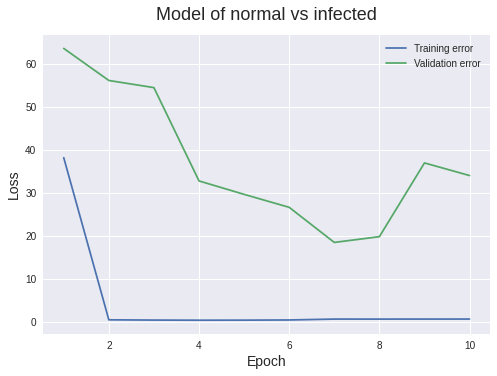

 10%|█         | 1/10 [00:03<00:34,  3.86s/it]

Epoch: 1/10 -  Time:2021-03-21 03:32:21.585746 Training Loss: 0.666 -  Validation Loss: 37.056 -  Validation Accuracy: 0.458 - 
F1 score: 0.517 Confusion Matrix: tensor([[ 63, 179],
        [ 28, 111]])
Validation loss decreased (inf --> 37.055938).  Saving model ...


 20%|██        | 2/10 [00:07<00:30,  3.86s/it]

Epoch: 2/10 -  Time:2021-03-21 03:32:25.462715 Training Loss: 0.701 -  Validation Loss: 1713.571 -  Validation Accuracy: 0.364 - 
F1 score: 0.535 Confusion Matrix: tensor([[  0, 242],
        [  0, 139]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:11<00:27,  3.86s/it]

Precision not computable, due to zero positives
Epoch: 3/10 -  Time:2021-03-21 03:32:29.334394 Training Loss: 0.977 -  Validation Loss: 462.643 -  Validation Accuracy: 0.633 - 
F1 score: 0.000 Confusion Matrix: tensor([[242,   0],
        [139,   0]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:15<00:23,  3.87s/it]

Precision not computable, due to zero positives
Epoch: 4/10 -  Time:2021-03-21 03:32:33.223716 Training Loss: 0.652 -  Validation Loss: 521.282 -  Validation Accuracy: 0.636 - 
F1 score: 0.000 Confusion Matrix: tensor([[242,   0],
        [139,   0]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:19<00:19,  3.87s/it]

Precision not computable, due to zero positives
Epoch: 5/10 -  Time:2021-03-21 03:32:37.080610 Training Loss: 0.653 -  Validation Loss: 536.060 -  Validation Accuracy: 0.636 - 
F1 score: 0.000 Confusion Matrix: tensor([[242,   0],
        [139,   0]])
EarlyStopping counter: 4 out of 5


 50%|█████     | 5/10 [00:23<00:23,  4.64s/it]

Precision not computable, due to zero positives
Epoch: 6/10 -  Time:2021-03-21 03:32:40.947152 Training Loss: 0.652 -  Validation Loss: 552.252 -  Validation Accuracy: 0.634 - 
F1 score: 0.000 Confusion Matrix: tensor([[242,   0],
        [139,   0]])
EarlyStopping counter: 5 out of 5
Early stopping


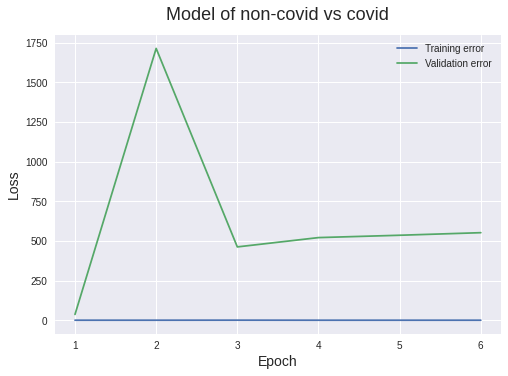

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 2, 'normal_noncovid': 2, 'covid_normal': 0, 'covid_covid': 6, 'covid_noncovid': 7, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.360
F1 Score: 0.675
Training batchsize 16 with lr 0.001...


 10%|█         | 1/10 [00:05<00:47,  5.28s/it]

Epoch: 1/10 -  Time:2021-03-21 03:32:46.456086 Training Loss: 2.078 -  Validation Loss: 13.589 -  Validation Accuracy: 0.499 - 
F1 score: 0.329 Confusion Matrix: tensor([[234,   0],
        [306,  75]])
Validation loss decreased (inf --> 13.589259).  Saving model ...


 20%|██        | 2/10 [00:10<00:42,  5.27s/it]

Epoch: 2/10 -  Time:2021-03-21 03:32:51.707417 Training Loss: 1.414 -  Validation Loss: 11.267 -  Validation Accuracy: 0.761 - 
F1 score: 0.835 Confusion Matrix: tensor([[ 93, 141],
        [  7, 374]])
Validation loss decreased (13.589259 --> 11.266765).  Saving model ...


 30%|███       | 3/10 [00:15<00:36,  5.28s/it]

Epoch: 3/10 -  Time:2021-03-21 03:32:56.991906 Training Loss: 1.038 -  Validation Loss: 9.158 -  Validation Accuracy: 0.809 - 
F1 score: 0.862 Confusion Matrix: tensor([[130, 104],
        [ 14, 367]])
Validation loss decreased (11.266765 --> 9.157621).  Saving model ...


 40%|████      | 4/10 [00:21<00:31,  5.28s/it]

Epoch: 4/10 -  Time:2021-03-21 03:33:02.273676 Training Loss: 0.740 -  Validation Loss: 6.584 -  Validation Accuracy: 0.827 - 
F1 score: 0.873 Confusion Matrix: tensor([[135,  99],
        [  9, 372]])
Validation loss decreased (9.157621 --> 6.583964).  Saving model ...


 50%|█████     | 5/10 [00:26<00:26,  5.28s/it]

Epoch: 5/10 -  Time:2021-03-21 03:33:07.568312 Training Loss: 0.553 -  Validation Loss: 8.086 -  Validation Accuracy: 0.752 - 
F1 score: 0.767 Confusion Matrix: tensor([[213,  21],
        [131, 250]])
EarlyStopping counter: 1 out of 5


 60%|██████    | 6/10 [00:31<00:21,  5.37s/it]

Epoch: 6/10 -  Time:2021-03-21 03:33:13.145292 Training Loss: 0.506 -  Validation Loss: 9.781 -  Validation Accuracy: 0.801 - 
F1 score: 0.855 Confusion Matrix: tensor([[124, 110],
        [ 14, 367]])
EarlyStopping counter: 2 out of 5


 70%|███████   | 7/10 [00:37<00:16,  5.36s/it]

Epoch: 7/10 -  Time:2021-03-21 03:33:18.462077 Training Loss: 0.368 -  Validation Loss: 4.332 -  Validation Accuracy: 0.858 - 
F1 score: 0.890 Confusion Matrix: tensor([[182,  52],
        [ 34, 347]])
Validation loss decreased (6.583964 --> 4.331921).  Saving model ...


 80%|████████  | 8/10 [00:42<00:10,  5.34s/it]

Epoch: 8/10 -  Time:2021-03-21 03:33:23.769789 Training Loss: 0.252 -  Validation Loss: 13.316 -  Validation Accuracy: 0.769 - 
F1 score: 0.843 Confusion Matrix: tensor([[ 98, 136],
        [  4, 377]])
EarlyStopping counter: 1 out of 5


 90%|█████████ | 9/10 [00:47<00:05,  5.33s/it]

Epoch: 9/10 -  Time:2021-03-21 03:33:29.068514 Training Loss: 0.225 -  Validation Loss: 5.478 -  Validation Accuracy: 0.856 - 
F1 score: 0.891 Confusion Matrix: tensor([[158,  76],
        [ 14, 367]])
EarlyStopping counter: 2 out of 5


100%|██████████| 10/10 [00:53<00:00,  5.32s/it]

Epoch: 10/10 -  Time:2021-03-21 03:33:34.339485 Training Loss: 0.235 -  Validation Loss: 16.140 -  Validation Accuracy: 0.738 - 
F1 score: 0.824 Confusion Matrix: tensor([[ 73, 161],
        [  1, 380]])
EarlyStopping counter: 3 out of 5


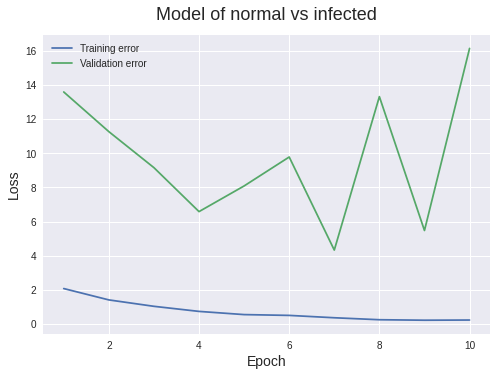

 10%|█         | 1/10 [00:03<00:34,  3.85s/it]

Epoch: 1/10 -  Time:2021-03-21 03:33:38.335056 Training Loss: 10.081 -  Validation Loss: 3.340 -  Validation Accuracy: 0.785 - 
F1 score: 0.669 Confusion Matrix: tensor([[216,  26],
        [ 56,  83]])
Validation loss decreased (inf --> 3.339515).  Saving model ...


 20%|██        | 2/10 [00:07<00:30,  3.86s/it]

Epoch: 2/10 -  Time:2021-03-21 03:33:42.212279 Training Loss: 3.226 -  Validation Loss: 3.100 -  Validation Accuracy: 0.767 - 
F1 score: 0.582 Confusion Matrix: tensor([[230,  12],
        [ 77,  62]])
Validation loss decreased (3.339515 --> 3.099922).  Saving model ...


 30%|███       | 3/10 [00:11<00:27,  3.87s/it]

Epoch: 3/10 -  Time:2021-03-21 03:33:46.107853 Training Loss: 2.061 -  Validation Loss: 11.303 -  Validation Accuracy: 0.644 - 
F1 score: 0.042 Confusion Matrix: tensor([[242,   0],
        [136,   3]])
EarlyStopping counter: 1 out of 5


 40%|████      | 4/10 [00:15<00:23,  3.87s/it]

Epoch: 4/10 -  Time:2021-03-21 03:33:49.965797 Training Loss: 1.701 -  Validation Loss: 1.902 -  Validation Accuracy: 0.759 - 
F1 score: 0.703 Confusion Matrix: tensor([[180,  62],
        [ 30, 109]])
Validation loss decreased (3.099922 --> 1.901575).  Saving model ...


 50%|█████     | 5/10 [00:19<00:19,  3.86s/it]

Epoch: 5/10 -  Time:2021-03-21 03:33:53.823301 Training Loss: 1.301 -  Validation Loss: 2.618 -  Validation Accuracy: 0.655 - 
F1 score: 0.629 Confusion Matrix: tensor([[137, 105],
        [ 27, 112]])
EarlyStopping counter: 1 out of 5


 60%|██████    | 6/10 [00:23<00:15,  3.86s/it]

Epoch: 6/10 -  Time:2021-03-21 03:33:57.679016 Training Loss: 0.862 -  Validation Loss: 2.151 -  Validation Accuracy: 0.774 - 
F1 score: 0.656 Confusion Matrix: tensor([[213,  29],
        [ 57,  82]])
EarlyStopping counter: 2 out of 5


 70%|███████   | 7/10 [00:27<00:11,  3.86s/it]

Epoch: 7/10 -  Time:2021-03-21 03:34:01.524272 Training Loss: 0.607 -  Validation Loss: 2.498 -  Validation Accuracy: 0.753 - 
F1 score: 0.510 Confusion Matrix: tensor([[238,   4],
        [ 90,  49]])
EarlyStopping counter: 3 out of 5


 80%|████████  | 8/10 [00:30<00:07,  3.85s/it]

Epoch: 8/10 -  Time:2021-03-21 03:34:05.362588 Training Loss: 0.390 -  Validation Loss: 2.592 -  Validation Accuracy: 0.731 - 
F1 score: 0.482 Confusion Matrix: tensor([[230,  12],
        [ 91,  48]])
EarlyStopping counter: 4 out of 5


 80%|████████  | 8/10 [00:34<00:08,  4.34s/it]

Epoch: 9/10 -  Time:2021-03-21 03:34:09.185120 Training Loss: 0.352 -  Validation Loss: 2.816 -  Validation Accuracy: 0.620 - 
F1 score: 0.619 Confusion Matrix: tensor([[118, 124],
        [ 21, 118]])
EarlyStopping counter: 5 out of 5
Early stopping


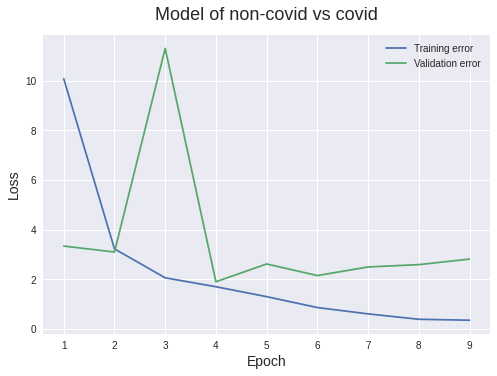

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 3, 'normal_noncovid': 3, 'covid_normal': 0, 'covid_covid': 5, 'covid_noncovid': 6, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.360
F1 Score: 0.615
Training batchsize 16 with lr 0.0001...


 10%|█         | 1/10 [00:05<00:47,  5.28s/it]

Epoch: 1/10 -  Time:2021-03-21 03:34:14.686752 Training Loss: 0.248 -  Validation Loss: 0.514 -  Validation Accuracy: 0.817 - 
F1 score: 0.862 Confusion Matrix: tensor([[146,  88],
        [ 26, 355]])
Validation loss decreased (inf --> 0.513705).  Saving model ...


 20%|██        | 2/10 [00:10<00:42,  5.27s/it]

Epoch: 2/10 -  Time:2021-03-21 03:34:19.931693 Training Loss: 0.127 -  Validation Loss: 0.461 -  Validation Accuracy: 0.828 - 
F1 score: 0.868 Confusion Matrix: tensor([[160,  74],
        [ 32, 349]])
Validation loss decreased (0.513705 --> 0.460837).  Saving model ...


 30%|███       | 3/10 [00:15<00:37,  5.30s/it]

Epoch: 3/10 -  Time:2021-03-21 03:34:25.284302 Training Loss: 0.097 -  Validation Loss: 0.445 -  Validation Accuracy: 0.828 - 
F1 score: 0.861 Confusion Matrix: tensor([[180,  54],
        [ 52, 329]])
Validation loss decreased (0.460837 --> 0.444549).  Saving model ...


 40%|████      | 4/10 [00:21<00:31,  5.30s/it]

Epoch: 4/10 -  Time:2021-03-21 03:34:30.583169 Training Loss: 0.123 -  Validation Loss: 0.425 -  Validation Accuracy: 0.818 - 
F1 score: 0.852 Confusion Matrix: tensor([[184,  50],
        [ 61, 320]])
Validation loss decreased (0.444549 --> 0.425463).  Saving model ...


 50%|█████     | 5/10 [00:26<00:26,  5.29s/it]

Epoch: 5/10 -  Time:2021-03-21 03:34:35.863286 Training Loss: 0.112 -  Validation Loss: 0.458 -  Validation Accuracy: 0.799 - 
F1 score: 0.845 Confusion Matrix: tensor([[158,  76],
        [ 47, 334]])
EarlyStopping counter: 1 out of 5


 60%|██████    | 6/10 [00:31<00:21,  5.30s/it]

Epoch: 6/10 -  Time:2021-03-21 03:34:41.179761 Training Loss: 0.073 -  Validation Loss: 0.427 -  Validation Accuracy: 0.838 - 
F1 score: 0.871 Confusion Matrix: tensor([[173,  61],
        [ 40, 341]])
EarlyStopping counter: 2 out of 5


 70%|███████   | 7/10 [00:37<00:15,  5.29s/it]

Epoch: 7/10 -  Time:2021-03-21 03:34:46.466964 Training Loss: 0.026 -  Validation Loss: 0.546 -  Validation Accuracy: 0.723 - 
F1 score: 0.723 Confusion Matrix: tensor([[216,  18],
        [155, 226]])
EarlyStopping counter: 3 out of 5


 80%|████████  | 8/10 [00:42<00:10,  5.30s/it]

Epoch: 8/10 -  Time:2021-03-21 03:34:51.760567 Training Loss: 0.032 -  Validation Loss: 0.400 -  Validation Accuracy: 0.833 - 
F1 score: 0.861 Confusion Matrix: tensor([[193,  41],
        [ 62, 319]])
Validation loss decreased (0.425463 --> 0.399731).  Saving model ...


 90%|█████████ | 9/10 [00:47<00:05,  5.31s/it]

Epoch: 9/10 -  Time:2021-03-21 03:34:57.119373 Training Loss: 0.021 -  Validation Loss: 0.442 -  Validation Accuracy: 0.839 - 
F1 score: 0.873 Confusion Matrix: tensor([[175,  59],
        [ 40, 341]])
EarlyStopping counter: 1 out of 5


100%|██████████| 10/10 [00:53<00:00,  5.31s/it]

Epoch: 10/10 -  Time:2021-03-21 03:35:02.536613 Training Loss: 0.082 -  Validation Loss: 0.618 -  Validation Accuracy: 0.721 - 
F1 score: 0.728 Confusion Matrix: tensor([[218,  16],
        [154, 227]])
EarlyStopping counter: 2 out of 5


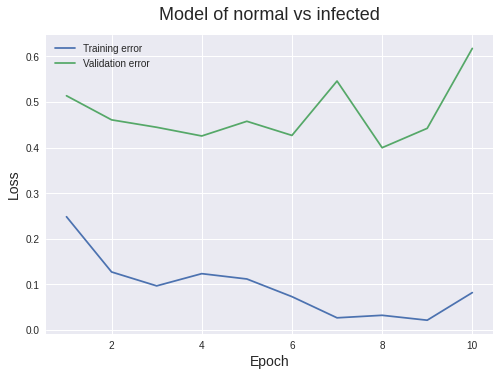

 10%|█         | 1/10 [00:04<00:38,  4.28s/it]

Epoch: 1/10 -  Time:2021-03-21 03:35:06.960311 Training Loss: 1.882 -  Validation Loss: 1.231 -  Validation Accuracy: 0.627 - 
F1 score: 0.027 Confusion Matrix: tensor([[237,   5],
        [137,   2]])
Validation loss decreased (inf --> 1.231362).  Saving model ...


 20%|██        | 2/10 [00:08<00:33,  4.16s/it]

Epoch: 2/10 -  Time:2021-03-21 03:35:10.851290 Training Loss: 1.034 -  Validation Loss: 1.307 -  Validation Accuracy: 0.632 - 
F1 score: 0.028 Confusion Matrix: tensor([[239,   3],
        [137,   2]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:12<00:28,  4.08s/it]

Epoch: 3/10 -  Time:2021-03-21 03:35:14.748876 Training Loss: 0.899 -  Validation Loss: 0.913 -  Validation Accuracy: 0.604 - 
F1 score: 0.096 Confusion Matrix: tensor([[222,  20],
        [131,   8]])
Validation loss decreased (1.231362 --> 0.913500).  Saving model ...


 40%|████      | 4/10 [00:15<00:24,  4.02s/it]

Epoch: 4/10 -  Time:2021-03-21 03:35:18.621351 Training Loss: 0.668 -  Validation Loss: 0.831 -  Validation Accuracy: 0.605 - 
F1 score: 0.118 Confusion Matrix: tensor([[221,  21],
        [129,  10]])
Validation loss decreased (0.913500 --> 0.830661).  Saving model ...


 50%|█████     | 5/10 [00:19<00:19,  3.97s/it]

Epoch: 5/10 -  Time:2021-03-21 03:35:22.492843 Training Loss: 0.633 -  Validation Loss: 1.017 -  Validation Accuracy: 0.633 - 
F1 score: 0.014 Confusion Matrix: tensor([[240,   2],
        [138,   1]])
EarlyStopping counter: 1 out of 5


 60%|██████    | 6/10 [00:23<00:15,  3.95s/it]

Epoch: 6/10 -  Time:2021-03-21 03:35:26.371185 Training Loss: 0.662 -  Validation Loss: 0.761 -  Validation Accuracy: 0.632 - 
F1 score: 0.079 Confusion Matrix: tensor([[235,   7],
        [133,   6]])
Validation loss decreased (0.830661 --> 0.760823).  Saving model ...


 70%|███████   | 7/10 [00:27<00:11,  3.93s/it]

Epoch: 7/10 -  Time:2021-03-21 03:35:30.283465 Training Loss: 0.530 -  Validation Loss: 0.960 -  Validation Accuracy: 0.626 - 
F1 score: 0.000 Confusion Matrix: tensor([[238,   4],
        [139,   0]])
EarlyStopping counter: 1 out of 5


 80%|████████  | 8/10 [00:31<00:07,  3.93s/it]

Epoch: 8/10 -  Time:2021-03-21 03:35:34.183977 Training Loss: 0.434 -  Validation Loss: 0.758 -  Validation Accuracy: 0.606 - 
F1 score: 0.026 Confusion Matrix: tensor([[228,  14],
        [137,   2]])
Validation loss decreased (0.760823 --> 0.758217).  Saving model ...


 90%|█████████ | 9/10 [00:35<00:03,  3.92s/it]

Epoch: 9/10 -  Time:2021-03-21 03:35:38.074198 Training Loss: 0.417 -  Validation Loss: 0.695 -  Validation Accuracy: 0.588 - 
F1 score: 0.203 Confusion Matrix: tensor([[204,  38],
        [119,  20]])
Validation loss decreased (0.758217 --> 0.694613).  Saving model ...


100%|██████████| 10/10 [00:39<00:00,  3.93s/it]

Epoch: 10/10 -  Time:2021-03-21 03:35:41.944745 Training Loss: 0.361 -  Validation Loss: 0.768 -  Validation Accuracy: 0.615 - 
F1 score: 0.039 Confusion Matrix: tensor([[231,  11],
        [136,   3]])
EarlyStopping counter: 1 out of 5


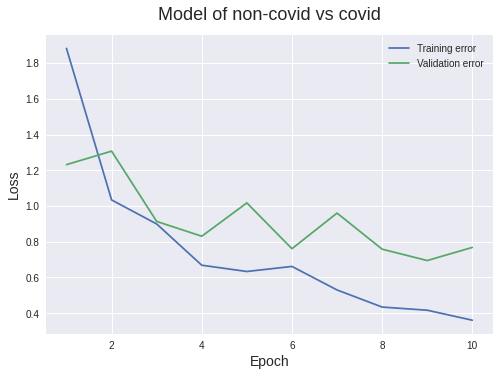

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 7, 'normal_noncovid': 7, 'covid_normal': 0, 'covid_covid': 1, 'covid_noncovid': 2, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.360
F1 Score: 0.343
Training batchsize 32 with lr 0.1...


 10%|█         | 1/10 [00:04<00:44,  4.98s/it]

Epoch: 1/10 -  Time:2021-03-21 03:35:47.137618 Training Loss: 50.317 -  Validation Loss: 52.884 -  Validation Accuracy: 0.804 - 
F1 score: 0.859 Confusion Matrix: tensor([[122, 112],
        [ 10, 371]])
Validation loss decreased (inf --> 52.883760).  Saving model ...


 20%|██        | 2/10 [00:09<00:39,  4.99s/it]

Epoch: 2/10 -  Time:2021-03-21 03:35:52.141913 Training Loss: 0.320 -  Validation Loss: 29.262 -  Validation Accuracy: 0.841 - 
F1 score: 0.876 Confusion Matrix: tensor([[152,  82],
        [ 20, 361]])
Validation loss decreased (52.883760 --> 29.262211).  Saving model ...


 30%|███       | 3/10 [00:14<00:34,  4.99s/it]

Epoch: 3/10 -  Time:2021-03-21 03:35:57.133005 Training Loss: 0.234 -  Validation Loss: 22.041 -  Validation Accuracy: 0.833 - 
F1 score: 0.881 Confusion Matrix: tensor([[164,  70],
        [ 26, 355]])
Validation loss decreased (29.262211 --> 22.040524).  Saving model ...


 40%|████      | 4/10 [00:20<00:30,  5.00s/it]

Epoch: 4/10 -  Time:2021-03-21 03:36:02.168345 Training Loss: 0.215 -  Validation Loss: 18.999 -  Validation Accuracy: 0.848 - 
F1 score: 0.881 Confusion Matrix: tensor([[174,  60],
        [ 34, 347]])
Validation loss decreased (22.040524 --> 18.998687).  Saving model ...


 50%|█████     | 5/10 [00:25<00:25,  5.01s/it]

Epoch: 5/10 -  Time:2021-03-21 03:36:07.193295 Training Loss: 0.205 -  Validation Loss: 23.031 -  Validation Accuracy: 0.808 - 
F1 score: 0.816 Confusion Matrix: tensor([[220,  14],
        [109, 272]])
EarlyStopping counter: 1 out of 5


 60%|██████    | 6/10 [00:30<00:20,  5.06s/it]

Epoch: 6/10 -  Time:2021-03-21 03:36:12.386693 Training Loss: 0.200 -  Validation Loss: 29.477 -  Validation Accuracy: 0.804 - 
F1 score: 0.814 Confusion Matrix: tensor([[226,   8],
        [114, 267]])
EarlyStopping counter: 2 out of 5


 70%|███████   | 7/10 [00:35<00:15,  5.04s/it]

Epoch: 7/10 -  Time:2021-03-21 03:36:17.359022 Training Loss: 0.176 -  Validation Loss: 37.079 -  Validation Accuracy: 0.753 - 
F1 score: 0.758 Confusion Matrix: tensor([[227,   7],
        [144, 237]])
EarlyStopping counter: 3 out of 5


 80%|████████  | 8/10 [00:40<00:10,  5.02s/it]

Epoch: 8/10 -  Time:2021-03-21 03:36:22.349956 Training Loss: 0.416 -  Validation Loss: 24.481 -  Validation Accuracy: 0.823 - 
F1 score: 0.837 Confusion Matrix: tensor([[212,  22],
        [ 91, 290]])
EarlyStopping counter: 4 out of 5


 80%|████████  | 8/10 [00:45<00:11,  5.64s/it]

Epoch: 9/10 -  Time:2021-03-21 03:36:27.311634 Training Loss: 0.420 -  Validation Loss: 32.180 -  Validation Accuracy: 0.738 - 
F1 score: 0.728 Confusion Matrix: tensor([[231,   3],
        [161, 220]])
EarlyStopping counter: 5 out of 5
Early stopping


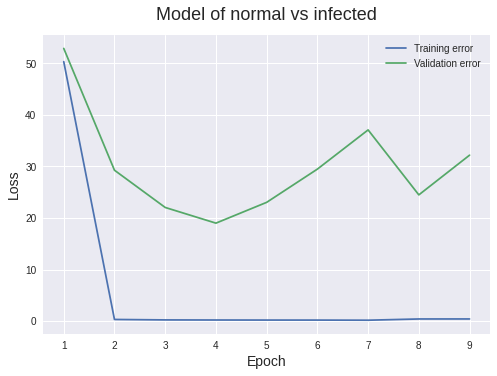

 10%|█         | 1/10 [00:03<00:32,  3.61s/it]

Epoch: 1/10 -  Time:2021-03-21 03:36:31.060076 Training Loss: 0.797 -  Validation Loss: 66.463 -  Validation Accuracy: 0.305 - 
F1 score: 0.410 Confusion Matrix: tensor([[ 24, 218],
        [ 47,  92]])
Validation loss decreased (inf --> 66.463297).  Saving model ...


 20%|██        | 2/10 [00:07<00:28,  3.61s/it]

Epoch: 2/10 -  Time:2021-03-21 03:36:34.681851 Training Loss: 0.654 -  Validation Loss: 123.720 -  Validation Accuracy: 0.629 - 
F1 score: 0.000 Confusion Matrix: tensor([[240,   2],
        [139,   0]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:10<00:25,  3.62s/it]

Epoch: 3/10 -  Time:2021-03-21 03:36:38.304488 Training Loss: 0.655 -  Validation Loss: 152.369 -  Validation Accuracy: 0.629 - 
F1 score: 0.000 Confusion Matrix: tensor([[240,   2],
        [139,   0]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:14<00:21,  3.64s/it]

Epoch: 4/10 -  Time:2021-03-21 03:36:41.997621 Training Loss: 0.653 -  Validation Loss: 125.542 -  Validation Accuracy: 0.630 - 
F1 score: 0.000 Confusion Matrix: tensor([[240,   2],
        [139,   0]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:18<00:18,  3.66s/it]

Epoch: 5/10 -  Time:2021-03-21 03:36:45.703039 Training Loss: 0.654 -  Validation Loss: 82.812 -  Validation Accuracy: 0.632 - 
F1 score: 0.000 Confusion Matrix: tensor([[241,   1],
        [139,   0]])
EarlyStopping counter: 4 out of 5


 50%|█████     | 5/10 [00:21<00:21,  4.39s/it]

Epoch: 6/10 -  Time:2021-03-21 03:36:49.429606 Training Loss: 0.656 -  Validation Loss: 132.678 -  Validation Accuracy: 0.629 - 
F1 score: 0.000 Confusion Matrix: tensor([[240,   2],
        [139,   0]])
EarlyStopping counter: 5 out of 5
Early stopping


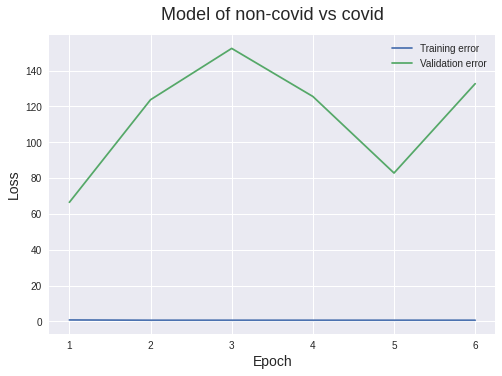

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 2, 'normal_noncovid': 5, 'covid_normal': 0, 'covid_covid': 6, 'covid_noncovid': 4, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.400
F1 Score: 0.623
Training batchsize 32 with lr 0.001...


 10%|█         | 1/10 [00:05<00:46,  5.15s/it]

Epoch: 1/10 -  Time:2021-03-21 03:36:54.785825 Training Loss: 1.991 -  Validation Loss: 2.429 -  Validation Accuracy: 0.803 - 
F1 score: 0.814 Confusion Matrix: tensor([[214,  20],
        [106, 275]])
Validation loss decreased (inf --> 2.428647).  Saving model ...


 20%|██        | 2/10 [00:10<00:40,  5.12s/it]

Epoch: 2/10 -  Time:2021-03-21 03:36:59.842245 Training Loss: 1.341 -  Validation Loss: 4.638 -  Validation Accuracy: 0.824 - 
F1 score: 0.856 Confusion Matrix: tensor([[183,  51],
        [ 58, 323]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:15<00:35,  5.08s/it]

Epoch: 3/10 -  Time:2021-03-21 03:37:04.840340 Training Loss: 0.731 -  Validation Loss: 4.075 -  Validation Accuracy: 0.813 - 
F1 score: 0.840 Confusion Matrix: tensor([[194,  40],
        [ 76, 305]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:20<00:30,  5.06s/it]

Epoch: 4/10 -  Time:2021-03-21 03:37:09.833465 Training Loss: 0.874 -  Validation Loss: 4.134 -  Validation Accuracy: 0.844 - 
F1 score: 0.875 Confusion Matrix: tensor([[183,  51],
        [ 45, 336]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:25<00:25,  5.03s/it]

Epoch: 5/10 -  Time:2021-03-21 03:37:14.804092 Training Loss: 0.474 -  Validation Loss: 3.579 -  Validation Accuracy: 0.838 - 
F1 score: 0.876 Confusion Matrix: tensor([[195,  39],
        [ 54, 327]])
EarlyStopping counter: 4 out of 5


 50%|█████     | 5/10 [00:30<00:30,  6.03s/it]

Epoch: 6/10 -  Time:2021-03-21 03:37:19.811339 Training Loss: 0.425 -  Validation Loss: 5.410 -  Validation Accuracy: 0.773 - 
F1 score: 0.827 Confusion Matrix: tensor([[148,  86],
        [ 52, 329]])
EarlyStopping counter: 5 out of 5
Early stopping


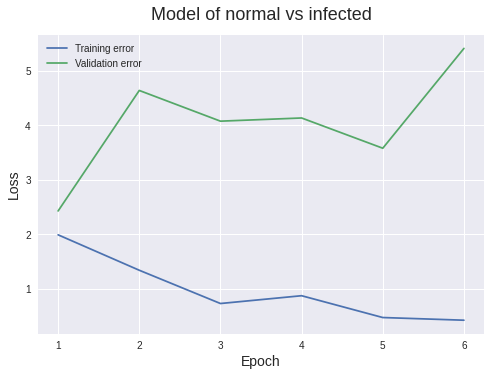

 10%|█         | 1/10 [00:03<00:32,  3.64s/it]

Epoch: 1/10 -  Time:2021-03-21 03:37:23.577807 Training Loss: 8.368 -  Validation Loss: 1.823 -  Validation Accuracy: 0.707 - 
F1 score: 0.685 Confusion Matrix: tensor([[147,  95],
        [ 17, 122]])
Validation loss decreased (inf --> 1.822717).  Saving model ...


 20%|██        | 2/10 [00:07<00:29,  3.64s/it]

Epoch: 2/10 -  Time:2021-03-21 03:37:27.222707 Training Loss: 5.348 -  Validation Loss: 5.221 -  Validation Accuracy: 0.591 - 
F1 score: 0.630 Confusion Matrix: tensor([[ 92, 150],
        [  6, 133]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:10<00:25,  3.64s/it]

Epoch: 3/10 -  Time:2021-03-21 03:37:30.860576 Training Loss: 3.949 -  Validation Loss: 1.252 -  Validation Accuracy: 0.810 - 
F1 score: 0.762 Confusion Matrix: tensor([[194,  48],
        [ 24, 115]])
Validation loss decreased (1.822717 --> 1.251511).  Saving model ...


 40%|████      | 4/10 [00:14<00:21,  3.64s/it]

Epoch: 4/10 -  Time:2021-03-21 03:37:34.510753 Training Loss: 3.106 -  Validation Loss: 15.099 -  Validation Accuracy: 0.374 - 
F1 score: 0.537 Confusion Matrix: tensor([[  5, 237],
        [  1, 138]])
EarlyStopping counter: 1 out of 5


 50%|█████     | 5/10 [00:18<00:18,  3.64s/it]

Epoch: 5/10 -  Time:2021-03-21 03:37:38.159978 Training Loss: 3.986 -  Validation Loss: 2.536 -  Validation Accuracy: 0.661 - 
F1 score: 0.310 Confusion Matrix: tensor([[223,  19],
        [110,  29]])
EarlyStopping counter: 2 out of 5


 60%|██████    | 6/10 [00:21<00:14,  3.64s/it]

Epoch: 6/10 -  Time:2021-03-21 03:37:41.786703 Training Loss: 2.639 -  Validation Loss: 1.204 -  Validation Accuracy: 0.766 - 
F1 score: 0.736 Confusion Matrix: tensor([[168,  74],
        [ 15, 124]])
Validation loss decreased (1.251511 --> 1.203917).  Saving model ...


 70%|███████   | 7/10 [00:25<00:10,  3.65s/it]

Epoch: 7/10 -  Time:2021-03-21 03:37:45.452958 Training Loss: 2.455 -  Validation Loss: 6.495 -  Validation Accuracy: 0.423 - 
F1 score: 0.555 Confusion Matrix: tensor([[ 24, 218],
        [  2, 137]])
EarlyStopping counter: 1 out of 5


 80%|████████  | 8/10 [00:29<00:07,  3.66s/it]

Epoch: 8/10 -  Time:2021-03-21 03:37:49.129211 Training Loss: 2.393 -  Validation Loss: 9.736 -  Validation Accuracy: 0.394 - 
F1 score: 0.546 Confusion Matrix: tensor([[ 11, 231],
        [  0, 139]])
EarlyStopping counter: 2 out of 5


 90%|█████████ | 9/10 [00:32<00:03,  3.67s/it]

Epoch: 9/10 -  Time:2021-03-21 03:37:52.817652 Training Loss: 2.157 -  Validation Loss: 5.475 -  Validation Accuracy: 0.422 - 
F1 score: 0.558 Confusion Matrix: tensor([[ 22, 220],
        [  0, 139]])
EarlyStopping counter: 3 out of 5


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]

Epoch: 10/10 -  Time:2021-03-21 03:37:56.486957 Training Loss: 1.641 -  Validation Loss: 1.486 -  Validation Accuracy: 0.672 - 
F1 score: 0.658 Confusion Matrix: tensor([[136, 106],
        [ 19, 120]])
EarlyStopping counter: 4 out of 5


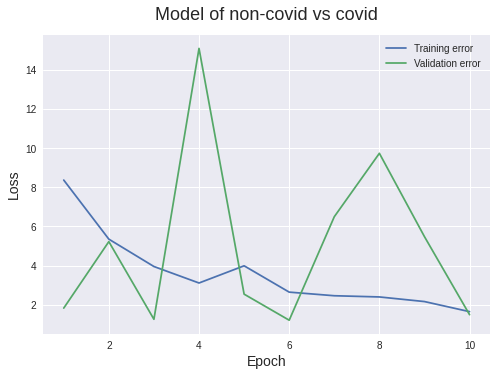

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 2, 'normal_noncovid': 3, 'covid_normal': 0, 'covid_covid': 6, 'covid_noncovid': 6, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.400
F1 Score: 0.658
Training batchsize 32 with lr 0.0001...


 10%|█         | 1/10 [00:05<00:45,  5.06s/it]

Epoch: 1/10 -  Time:2021-03-21 03:38:01.775315 Training Loss: 0.230 -  Validation Loss: 0.667 -  Validation Accuracy: 0.715 - 
F1 score: 0.806 Confusion Matrix: tensor([[ 76, 158],
        [ 17, 364]])
Validation loss decreased (inf --> 0.667104).  Saving model ...


 20%|██        | 2/10 [00:10<00:40,  5.02s/it]

Epoch: 2/10 -  Time:2021-03-21 03:38:06.719590 Training Loss: 0.095 -  Validation Loss: 0.648 -  Validation Accuracy: 0.836 - 
F1 score: 0.879 Confusion Matrix: tensor([[162,  72],
        [ 26, 355]])
Validation loss decreased (0.667104 --> 0.647677).  Saving model ...


 30%|███       | 3/10 [00:14<00:35,  5.01s/it]

Epoch: 3/10 -  Time:2021-03-21 03:38:11.691458 Training Loss: 0.064 -  Validation Loss: 0.663 -  Validation Accuracy: 0.808 - 
F1 score: 0.854 Confusion Matrix: tensor([[160,  74],
        [ 42, 339]])
EarlyStopping counter: 1 out of 5


 40%|████      | 4/10 [00:19<00:30,  5.00s/it]

Epoch: 4/10 -  Time:2021-03-21 03:38:16.684141 Training Loss: 0.058 -  Validation Loss: 0.674 -  Validation Accuracy: 0.617 - 
F1 score: 0.760 Confusion Matrix: tensor([[  1, 233],
        [  5, 376]])
EarlyStopping counter: 2 out of 5


 50%|█████     | 5/10 [00:25<00:25,  5.04s/it]

Epoch: 5/10 -  Time:2021-03-21 03:38:21.816808 Training Loss: 0.046 -  Validation Loss: 0.641 -  Validation Accuracy: 0.650 - 
F1 score: 0.775 Confusion Matrix: tensor([[ 35, 199],
        [ 14, 367]])
Validation loss decreased (0.647677 --> 0.641411).  Saving model ...


 60%|██████    | 6/10 [00:30<00:20,  5.05s/it]

Epoch: 6/10 -  Time:2021-03-21 03:38:26.888653 Training Loss: 0.023 -  Validation Loss: 0.663 -  Validation Accuracy: 0.626 - 
F1 score: 0.763 Confusion Matrix: tensor([[ 10, 224],
        [  8, 373]])
EarlyStopping counter: 1 out of 5


 70%|███████   | 7/10 [00:35<00:15,  5.03s/it]

Epoch: 7/10 -  Time:2021-03-21 03:38:31.865921 Training Loss: 0.015 -  Validation Loss: 0.644 -  Validation Accuracy: 0.802 - 
F1 score: 0.838 Confusion Matrix: tensor([[199,  35],
        [ 81, 300]])
EarlyStopping counter: 2 out of 5


 80%|████████  | 8/10 [00:40<00:10,  5.02s/it]

Epoch: 8/10 -  Time:2021-03-21 03:38:36.850119 Training Loss: 0.023 -  Validation Loss: 0.644 -  Validation Accuracy: 0.850 - 
F1 score: 0.873 Confusion Matrix: tensor([[189,  45],
        [ 51, 330]])
EarlyStopping counter: 3 out of 5


 90%|█████████ | 9/10 [00:45<00:05,  5.00s/it]

Epoch: 9/10 -  Time:2021-03-21 03:38:41.815035 Training Loss: 0.008 -  Validation Loss: 0.661 -  Validation Accuracy: 0.837 - 
F1 score: 0.868 Confusion Matrix: tensor([[168,  66],
        [ 38, 343]])
EarlyStopping counter: 4 out of 5


 90%|█████████ | 9/10 [00:50<00:05,  5.56s/it]

Epoch: 10/10 -  Time:2021-03-21 03:38:46.792126 Training Loss: 0.002 -  Validation Loss: 0.664 -  Validation Accuracy: 0.802 - 
F1 score: 0.835 Confusion Matrix: tensor([[181,  53],
        [ 70, 311]])
EarlyStopping counter: 5 out of 5
Early stopping


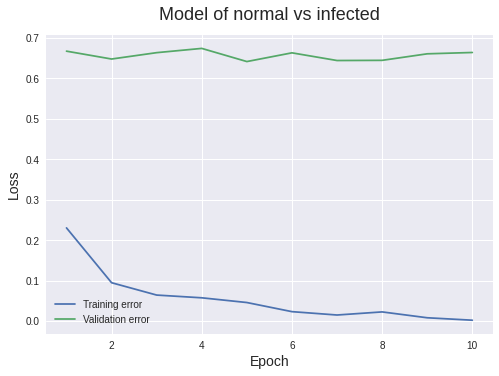

 10%|█         | 1/10 [00:03<00:32,  3.60s/it]

Epoch: 1/10 -  Time:2021-03-21 03:38:50.517609 Training Loss: 1.442 -  Validation Loss: 0.710 -  Validation Accuracy: 0.392 - 
F1 score: 0.515 Confusion Matrix: tensor([[ 26, 216],
        [ 16, 123]])
Validation loss decreased (inf --> 0.709638).  Saving model ...


 20%|██        | 2/10 [00:07<00:28,  3.60s/it]

Epoch: 2/10 -  Time:2021-03-21 03:38:54.117774 Training Loss: 0.751 -  Validation Loss: 0.711 -  Validation Accuracy: 0.397 - 
F1 score: 0.354 Confusion Matrix: tensor([[ 88, 154],
        [ 76,  63]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:10<00:25,  3.60s/it]

Epoch: 3/10 -  Time:2021-03-21 03:38:57.738854 Training Loss: 0.628 -  Validation Loss: 0.716 -  Validation Accuracy: 0.323 - 
F1 score: 0.424 Confusion Matrix: tensor([[ 28, 214],
        [ 44,  95]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:14<00:21,  3.60s/it]

Epoch: 4/10 -  Time:2021-03-21 03:39:01.341256 Training Loss: 0.543 -  Validation Loss: 0.716 -  Validation Accuracy: 0.352 - 
F1 score: 0.515 Confusion Matrix: tensor([[  3, 239],
        [  8, 131]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:18<00:18,  3.60s/it]

Epoch: 5/10 -  Time:2021-03-21 03:39:04.942849 Training Loss: 0.500 -  Validation Loss: 0.717 -  Validation Accuracy: 0.365 - 
F1 score: 0.533 Confusion Matrix: tensor([[  1, 241],
        [  1, 138]])
EarlyStopping counter: 4 out of 5


 60%|██████    | 6/10 [00:21<00:14,  3.61s/it]

Epoch: 6/10 -  Time:2021-03-21 03:39:08.564247 Training Loss: 0.475 -  Validation Loss: 0.705 -  Validation Accuracy: 0.368 - 
F1 score: 0.534 Confusion Matrix: tensor([[  2, 240],
        [  1, 138]])
Validation loss decreased (0.709638 --> 0.704782).  Saving model ...


 70%|███████   | 7/10 [00:25<00:10,  3.62s/it]

Epoch: 7/10 -  Time:2021-03-21 03:39:12.202976 Training Loss: 0.511 -  Validation Loss: 0.701 -  Validation Accuracy: 0.369 - 
F1 score: 0.469 Confusion Matrix: tensor([[ 35, 207],
        [ 33, 106]])
Validation loss decreased (0.704782 --> 0.700763).  Saving model ...


 80%|████████  | 8/10 [00:28<00:07,  3.63s/it]

Epoch: 8/10 -  Time:2021-03-21 03:39:15.844425 Training Loss: 0.407 -  Validation Loss: 0.699 -  Validation Accuracy: 0.370 - 
F1 score: 0.537 Confusion Matrix: tensor([[  2, 240],
        [  0, 139]])
Validation loss decreased (0.700763 --> 0.699022).  Saving model ...


 90%|█████████ | 9/10 [00:32<00:03,  3.63s/it]

Epoch: 9/10 -  Time:2021-03-21 03:39:19.483853 Training Loss: 0.337 -  Validation Loss: 0.699 -  Validation Accuracy: 0.368 - 
F1 score: 0.534 Confusion Matrix: tensor([[  2, 240],
        [  1, 138]])
EarlyStopping counter: 1 out of 5


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]

Epoch: 10/10 -  Time:2021-03-21 03:39:23.105329 Training Loss: 0.260 -  Validation Loss: 0.690 -  Validation Accuracy: 0.441 - 
F1 score: 0.540 Confusion Matrix: tensor([[ 43, 199],
        [ 14, 125]])
Validation loss decreased (0.699022 --> 0.689963).  Saving model ...


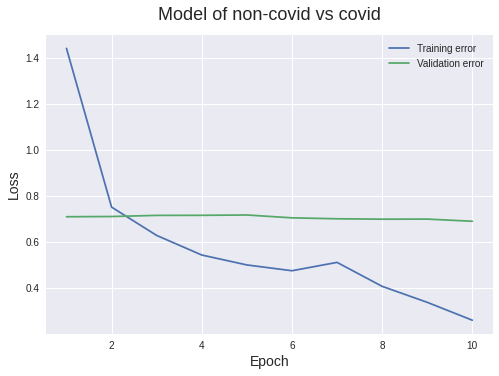

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 0, 'normal_noncovid': 0, 'covid_normal': 0, 'covid_covid': 8, 'covid_noncovid': 9, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.520
F1 Score: 0.786
Training batchsize 64 with lr 0.1...


 10%|█         | 1/10 [00:04<00:44,  4.96s/it]

Epoch: 1/10 -  Time:2021-03-21 03:39:28.349673 Training Loss: 122.617 -  Validation Loss: 182.700 -  Validation Accuracy: 0.778 - 
F1 score: 0.844 Confusion Matrix: tensor([[111, 123],
        [ 13, 368]])
Validation loss decreased (inf --> 182.699705).  Saving model ...


 20%|██        | 2/10 [00:09<00:39,  4.93s/it]

Epoch: 2/10 -  Time:2021-03-21 03:39:33.218349 Training Loss: 0.690 -  Validation Loss: 61.449 -  Validation Accuracy: 0.833 - 
F1 score: 0.865 Confusion Matrix: tensor([[175,  59],
        [ 46, 335]])
Validation loss decreased (182.699705 --> 61.448607).  Saving model ...


 30%|███       | 3/10 [00:14<00:34,  4.93s/it]

Epoch: 3/10 -  Time:2021-03-21 03:39:38.132442 Training Loss: 0.389 -  Validation Loss: 53.427 -  Validation Accuracy: 0.803 - 
F1 score: 0.831 Confusion Matrix: tensor([[189,  45],
        [ 78, 303]])
Validation loss decreased (61.448607 --> 53.427320).  Saving model ...


 40%|████      | 4/10 [00:19<00:29,  4.91s/it]

Epoch: 4/10 -  Time:2021-03-21 03:39:43.023489 Training Loss: 0.334 -  Validation Loss: 53.205 -  Validation Accuracy: 0.804 - 
F1 score: 0.837 Confusion Matrix: tensor([[190,  44],
        [ 75, 306]])
Validation loss decreased (53.427320 --> 53.205156).  Saving model ...


 50%|█████     | 5/10 [00:24<00:24,  4.91s/it]

Epoch: 5/10 -  Time:2021-03-21 03:39:47.923394 Training Loss: 0.280 -  Validation Loss: 48.188 -  Validation Accuracy: 0.836 - 
F1 score: 0.868 Confusion Matrix: tensor([[181,  53],
        [ 48, 333]])
Validation loss decreased (53.205156 --> 48.187516).  Saving model ...


 60%|██████    | 6/10 [00:29<00:19,  4.91s/it]

Epoch: 6/10 -  Time:2021-03-21 03:39:52.846738 Training Loss: 0.280 -  Validation Loss: 51.513 -  Validation Accuracy: 0.800 - 
F1 score: 0.834 Confusion Matrix: tensor([[182,  52],
        [ 71, 310]])
EarlyStopping counter: 1 out of 5


 70%|███████   | 7/10 [00:34<00:14,  4.92s/it]

Epoch: 7/10 -  Time:2021-03-21 03:39:57.772401 Training Loss: 0.211 -  Validation Loss: 52.741 -  Validation Accuracy: 0.798 - 
F1 score: 0.829 Confusion Matrix: tensor([[183,  51],
        [ 75, 306]])
EarlyStopping counter: 2 out of 5


 80%|████████  | 8/10 [00:39<00:09,  4.92s/it]

Epoch: 8/10 -  Time:2021-03-21 03:40:02.713752 Training Loss: 0.199 -  Validation Loss: 104.989 -  Validation Accuracy: 0.715 - 
F1 score: 0.807 Confusion Matrix: tensor([[ 81, 153],
        [ 20, 361]])
EarlyStopping counter: 3 out of 5


 90%|█████████ | 9/10 [00:44<00:04,  4.92s/it]

Epoch: 9/10 -  Time:2021-03-21 03:40:07.630610 Training Loss: 0.186 -  Validation Loss: 51.226 -  Validation Accuracy: 0.775 - 
F1 score: 0.814 Confusion Matrix: tensor([[179,  55],
        [ 82, 299]])
EarlyStopping counter: 4 out of 5


 90%|█████████ | 9/10 [00:49<00:05,  5.46s/it]

Epoch: 10/10 -  Time:2021-03-21 03:40:12.545816 Training Loss: 0.155 -  Validation Loss: 61.412 -  Validation Accuracy: 0.764 - 
F1 score: 0.809 Confusion Matrix: tensor([[169,  65],
        [ 78, 303]])
EarlyStopping counter: 5 out of 5
Early stopping


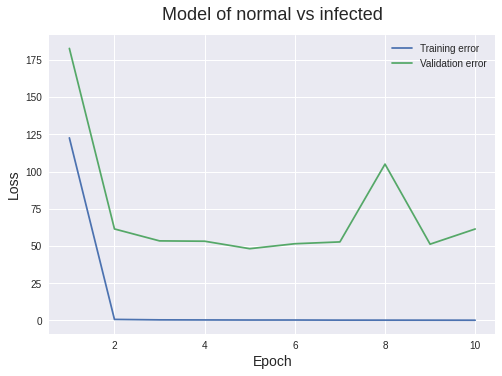

 10%|█         | 1/10 [00:03<00:31,  3.53s/it]

Epoch: 1/10 -  Time:2021-03-21 03:40:16.211467 Training Loss: 1.157 -  Validation Loss: 109.480 -  Validation Accuracy: 0.524 - 
F1 score: 0.022 Confusion Matrix: tensor([[198,  44],
        [137,   2]])
Validation loss decreased (inf --> 109.480291).  Saving model ...


 20%|██        | 2/10 [00:07<00:28,  3.54s/it]

Epoch: 2/10 -  Time:2021-03-21 03:40:19.762641 Training Loss: 0.659 -  Validation Loss: 111.101 -  Validation Accuracy: 0.517 - 
F1 score: 0.021 Confusion Matrix: tensor([[195,  47],
        [137,   2]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:10<00:24,  3.54s/it]

Epoch: 3/10 -  Time:2021-03-21 03:40:23.294978 Training Loss: 0.682 -  Validation Loss: 65.951 -  Validation Accuracy: 0.342 - 
F1 score: 0.246 Confusion Matrix: tensor([[ 89, 153],
        [ 98,  41]])
Validation loss decreased (109.480291 --> 65.951345).  Saving model ...


 40%|████      | 4/10 [00:14<00:21,  3.54s/it]

Epoch: 4/10 -  Time:2021-03-21 03:40:26.841770 Training Loss: 0.658 -  Validation Loss: 107.017 -  Validation Accuracy: 0.295 - 
F1 score: 0.336 Confusion Matrix: tensor([[ 44, 198],
        [ 71,  68]])
EarlyStopping counter: 1 out of 5


 50%|█████     | 5/10 [00:17<00:17,  3.54s/it]

Epoch: 5/10 -  Time:2021-03-21 03:40:30.371873 Training Loss: 0.658 -  Validation Loss: 115.489 -  Validation Accuracy: 0.288 - 
F1 score: 0.331 Confusion Matrix: tensor([[ 43, 199],
        [ 72,  67]])
EarlyStopping counter: 2 out of 5


 60%|██████    | 6/10 [00:21<00:14,  3.53s/it]

Epoch: 6/10 -  Time:2021-03-21 03:40:33.886028 Training Loss: 0.659 -  Validation Loss: 104.081 -  Validation Accuracy: 0.298 - 
F1 score: 0.341 Confusion Matrix: tensor([[ 45, 197],
        [ 70,  69]])
EarlyStopping counter: 3 out of 5


 70%|███████   | 7/10 [00:24<00:10,  3.53s/it]

Epoch: 7/10 -  Time:2021-03-21 03:40:37.415079 Training Loss: 0.659 -  Validation Loss: 112.596 -  Validation Accuracy: 0.285 - 
F1 score: 0.327 Confusion Matrix: tensor([[ 43, 199],
        [ 73,  66]])
EarlyStopping counter: 4 out of 5


 80%|████████  | 8/10 [00:28<00:07,  3.54s/it]

Epoch: 8/10 -  Time:2021-03-21 03:40:40.962067 Training Loss: 0.662 -  Validation Loss: 55.266 -  Validation Accuracy: 0.572 - 
F1 score: 0.012 Confusion Matrix: tensor([[217,  25],
        [138,   1]])
Validation loss decreased (65.951345 --> 55.266259).  Saving model ...


 90%|█████████ | 9/10 [00:31<00:03,  3.54s/it]

Epoch: 9/10 -  Time:2021-03-21 03:40:44.503575 Training Loss: 0.661 -  Validation Loss: 52.914 -  Validation Accuracy: 0.581 - 
F1 score: 0.012 Confusion Matrix: tensor([[220,  22],
        [138,   1]])
Validation loss decreased (55.266259 --> 52.913795).  Saving model ...


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]

Epoch: 10/10 -  Time:2021-03-21 03:40:48.018469 Training Loss: 0.658 -  Validation Loss: 59.663 -  Validation Accuracy: 0.569 - 
F1 score: 0.012 Confusion Matrix: tensor([[216,  26],
        [138,   1]])
EarlyStopping counter: 1 out of 5


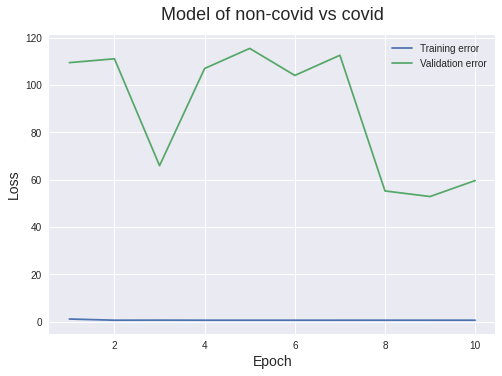

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 8, 'normal_noncovid': 9, 'covid_normal': 0, 'covid_covid': 0, 'covid_noncovid': 0, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.320
F1 Score: 0.239
Training batchsize 64 with lr 0.001...


 10%|█         | 1/10 [00:04<00:43,  4.83s/it]

Epoch: 1/10 -  Time:2021-03-21 03:40:53.051408 Training Loss: 1.986 -  Validation Loss: 1.240 -  Validation Accuracy: 0.811 - 
F1 score: 0.842 Confusion Matrix: tensor([[190,  44],
        [ 72, 309]])
Validation loss decreased (inf --> 1.240081).  Saving model ...


 20%|██        | 2/10 [00:09<00:38,  4.83s/it]

Epoch: 2/10 -  Time:2021-03-21 03:40:57.875314 Training Loss: 0.979 -  Validation Loss: 1.908 -  Validation Accuracy: 0.822 - 
F1 score: 0.859 Confusion Matrix: tensor([[177,  57],
        [ 51, 330]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:14<00:33,  4.82s/it]

Epoch: 3/10 -  Time:2021-03-21 03:41:02.689775 Training Loss: 0.735 -  Validation Loss: 13.774 -  Validation Accuracy: 0.618 - 
F1 score: 0.765 Confusion Matrix: tensor([[  0, 234],
        [  0, 381]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:19<00:29,  4.85s/it]

Epoch: 4/10 -  Time:2021-03-21 03:41:07.594183 Training Loss: 0.398 -  Validation Loss: 1.785 -  Validation Accuracy: 0.802 - 
F1 score: 0.829 Confusion Matrix: tensor([[204,  30],
        [ 90, 291]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:24<00:24,  4.84s/it]

Epoch: 5/10 -  Time:2021-03-21 03:41:12.411699 Training Loss: 0.465 -  Validation Loss: 4.933 -  Validation Accuracy: 0.706 - 
F1 score: 0.806 Confusion Matrix: tensor([[ 62, 172],
        [  8, 373]])
EarlyStopping counter: 4 out of 5


 50%|█████     | 5/10 [00:28<00:28,  5.80s/it]

Epoch: 6/10 -  Time:2021-03-21 03:41:17.230484 Training Loss: 0.290 -  Validation Loss: 2.050 -  Validation Accuracy: 0.817 - 
F1 score: 0.858 Confusion Matrix: tensor([[160,  74],
        [ 39, 342]])
EarlyStopping counter: 5 out of 5
Early stopping


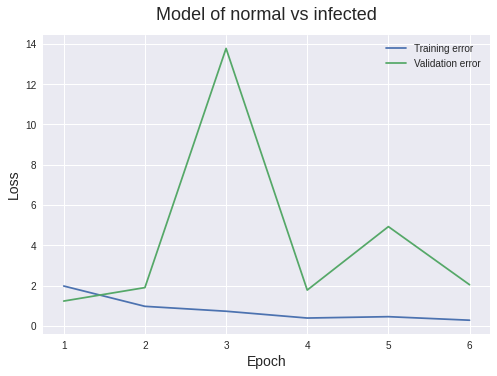

 10%|█         | 1/10 [00:03<00:31,  3.54s/it]

Epoch: 1/10 -  Time:2021-03-21 03:41:20.901778 Training Loss: 7.903 -  Validation Loss: 0.668 -  Validation Accuracy: 0.835 - 
F1 score: 0.788 Confusion Matrix: tensor([[201,  41],
        [ 22, 117]])
Validation loss decreased (inf --> 0.668096).  Saving model ...


 20%|██        | 2/10 [00:07<00:28,  3.54s/it]

Epoch: 2/10 -  Time:2021-03-21 03:41:24.440205 Training Loss: 3.885 -  Validation Loss: 1.248 -  Validation Accuracy: 0.758 - 
F1 score: 0.739 Confusion Matrix: tensor([[159,  83],
        [  9, 130]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:10<00:24,  3.54s/it]

Epoch: 3/10 -  Time:2021-03-21 03:41:27.993507 Training Loss: 1.846 -  Validation Loss: 3.219 -  Validation Accuracy: 0.423 - 
F1 score: 0.553 Confusion Matrix: tensor([[ 25, 217],
        [  3, 136]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:14<00:21,  3.54s/it]

Epoch: 4/10 -  Time:2021-03-21 03:41:31.536284 Training Loss: 2.011 -  Validation Loss: 1.744 -  Validation Accuracy: 0.562 - 
F1 score: 0.547 Confusion Matrix: tensor([[113, 129],
        [ 38, 101]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:17<00:17,  3.54s/it]

Epoch: 5/10 -  Time:2021-03-21 03:41:35.053048 Training Loss: 1.767 -  Validation Loss: 1.369 -  Validation Accuracy: 0.641 - 
F1 score: 0.655 Confusion Matrix: tensor([[114, 128],
        [  9, 130]])
EarlyStopping counter: 4 out of 5


 60%|██████    | 6/10 [00:21<00:14,  3.54s/it]

Epoch: 6/10 -  Time:2021-03-21 03:41:38.614629 Training Loss: 2.146 -  Validation Loss: 0.590 -  Validation Accuracy: 0.837 - 
F1 score: 0.775 Confusion Matrix: tensor([[212,  30],
        [ 32, 107]])
Validation loss decreased (0.668096 --> 0.589959).  Saving model ...


 70%|███████   | 7/10 [00:24<00:10,  3.54s/it]

Epoch: 7/10 -  Time:2021-03-21 03:41:42.165547 Training Loss: 1.879 -  Validation Loss: 2.004 -  Validation Accuracy: 0.455 - 
F1 score: 0.565 Confusion Matrix: tensor([[ 38, 204],
        [  4, 135]])
EarlyStopping counter: 1 out of 5


 80%|████████  | 8/10 [00:28<00:07,  3.55s/it]

Epoch: 8/10 -  Time:2021-03-21 03:41:45.735306 Training Loss: 1.379 -  Validation Loss: 1.101 -  Validation Accuracy: 0.688 - 
F1 score: 0.693 Confusion Matrix: tensor([[128, 114],
        [  5, 134]])
EarlyStopping counter: 2 out of 5


 90%|█████████ | 9/10 [00:31<00:03,  3.55s/it]

Epoch: 9/10 -  Time:2021-03-21 03:41:49.284843 Training Loss: 1.764 -  Validation Loss: 0.651 -  Validation Accuracy: 0.803 - 
F1 score: 0.768 Confusion Matrix: tensor([[182,  60],
        [ 15, 124]])
EarlyStopping counter: 3 out of 5


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]

Epoch: 10/10 -  Time:2021-03-21 03:41:52.834465 Training Loss: 1.410 -  Validation Loss: 1.356 -  Validation Accuracy: 0.668 - 
F1 score: 0.679 Confusion Matrix: tensor([[122, 120],
        [  6, 133]])
EarlyStopping counter: 4 out of 5


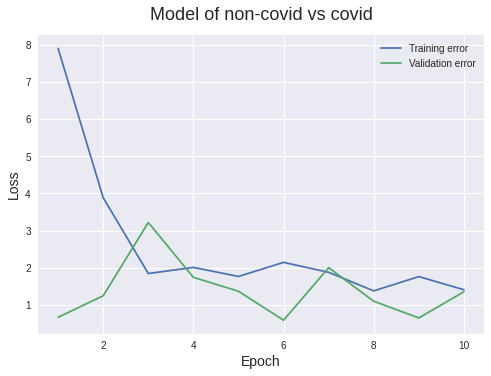

  0%|          | 0/10 [00:00<?, ?it/s]

{'normal_normal': 8, 'normal_covid': 4, 'normal_noncovid': 1, 'covid_normal': 0, 'covid_covid': 4, 'covid_noncovid': 8, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.240
F1 Score: 0.608
Training batchsize 64 with lr 0.0001...


 10%|█         | 1/10 [00:04<00:43,  4.85s/it]

Epoch: 1/10 -  Time:2021-03-21 03:41:57.900847 Training Loss: 0.239 -  Validation Loss: 0.643 -  Validation Accuracy: 0.835 - 
F1 score: 0.867 Confusion Matrix: tensor([[184,  50],
        [ 51, 330]])
Validation loss decreased (inf --> 0.642513).  Saving model ...


 20%|██        | 2/10 [00:09<00:38,  4.87s/it]

Epoch: 2/10 -  Time:2021-03-21 03:42:02.800831 Training Loss: 0.085 -  Validation Loss: 0.642 -  Validation Accuracy: 0.721 - 
F1 score: 0.730 Confusion Matrix: tensor([[215,  19],
        [151, 230]])
Validation loss decreased (0.642513 --> 0.642429).  Saving model ...


 30%|███       | 3/10 [00:14<00:34,  4.88s/it]

Epoch: 3/10 -  Time:2021-03-21 03:42:07.711658 Training Loss: 0.052 -  Validation Loss: 0.652 -  Validation Accuracy: 0.787 - 
F1 score: 0.829 Confusion Matrix: tensor([[162,  72],
        [ 60, 321]])
EarlyStopping counter: 1 out of 5


 40%|████      | 4/10 [00:19<00:29,  4.89s/it]

Epoch: 4/10 -  Time:2021-03-21 03:42:12.620702 Training Loss: 0.036 -  Validation Loss: 0.648 -  Validation Accuracy: 0.735 - 
F1 score: 0.753 Confusion Matrix: tensor([[199,  35],
        [130, 251]])
EarlyStopping counter: 2 out of 5


 50%|█████     | 5/10 [00:24<00:24,  4.90s/it]

Epoch: 5/10 -  Time:2021-03-21 03:42:17.540820 Training Loss: 0.023 -  Validation Loss: 0.652 -  Validation Accuracy: 0.617 - 
F1 score: 0.578 Confusion Matrix: tensor([[219,  15],
        [220, 161]])
EarlyStopping counter: 3 out of 5


 60%|██████    | 6/10 [00:29<00:19,  4.89s/it]

Epoch: 6/10 -  Time:2021-03-21 03:42:22.407308 Training Loss: 0.015 -  Validation Loss: 0.651 -  Validation Accuracy: 0.776 - 
F1 score: 0.801 Confusion Matrix: tensor([[205,  29],
        [107, 274]])
EarlyStopping counter: 4 out of 5


 60%|██████    | 6/10 [00:34<00:22,  5.70s/it]

Epoch: 7/10 -  Time:2021-03-21 03:42:27.267878 Training Loss: 0.007 -  Validation Loss: 0.651 -  Validation Accuracy: 0.710 - 
F1 score: 0.716 Confusion Matrix: tensor([[210,  24],
        [155, 226]])
EarlyStopping counter: 5 out of 5
Early stopping


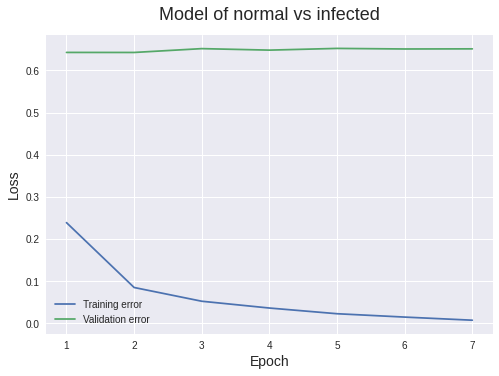

 10%|█         | 1/10 [00:03<00:31,  3.55s/it]

Epoch: 1/10 -  Time:2021-03-21 03:42:30.951031 Training Loss: 1.443 -  Validation Loss: 0.671 -  Validation Accuracy: 0.635 - 
F1 score: 0.014 Confusion Matrix: tensor([[241,   1],
        [138,   1]])
Validation loss decreased (inf --> 0.670527).  Saving model ...


 20%|██        | 2/10 [00:07<00:28,  3.54s/it]

Epoch: 2/10 -  Time:2021-03-21 03:42:34.495347 Training Loss: 0.568 -  Validation Loss: 0.675 -  Validation Accuracy: 0.641 - 
F1 score: 0.055 Confusion Matrix: tensor([[240,   2],
        [135,   4]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:10<00:24,  3.54s/it]

Epoch: 3/10 -  Time:2021-03-21 03:42:38.039584 Training Loss: 0.522 -  Validation Loss: 0.679 -  Validation Accuracy: 0.653 - 
F1 score: 0.132 Confusion Matrix: tensor([[239,   3],
        [129,  10]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:14<00:21,  3.54s/it]

Epoch: 4/10 -  Time:2021-03-21 03:42:41.572317 Training Loss: 0.491 -  Validation Loss: 0.684 -  Validation Accuracy: 0.716 - 
F1 score: 0.550 Confusion Matrix: tensor([[207,  35],
        [ 73,  66]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:17<00:17,  3.54s/it]

Epoch: 5/10 -  Time:2021-03-21 03:42:45.105464 Training Loss: 0.418 -  Validation Loss: 0.687 -  Validation Accuracy: 0.672 - 
F1 score: 0.233 Confusion Matrix: tensor([[237,   5],
        [120,  19]])
EarlyStopping counter: 4 out of 5


 50%|█████     | 5/10 [00:21<00:21,  4.25s/it]

Epoch: 6/10 -  Time:2021-03-21 03:42:48.657266 Training Loss: 0.387 -  Validation Loss: 0.690 -  Validation Accuracy: 0.677 - 
F1 score: 0.599 Confusion Matrix: tensor([[166,  76],
        [ 47,  92]])
EarlyStopping counter: 5 out of 5
Early stopping


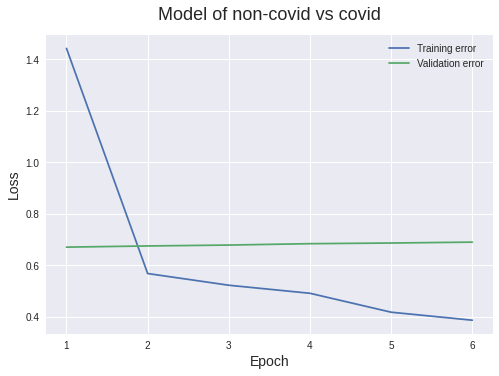

{'normal_normal': 8, 'normal_covid': 8, 'normal_noncovid': 9, 'covid_normal': 0, 'covid_covid': 0, 'covid_noncovid': 0, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 0}
Testing Accuracy: 0.320
F1 Score: 0.239
Fine tune final: {'16_0.1': 0.6749999999999999, '16_0.001': 0.6153846153846153, '16_0.0001': 0.34285714285714286, '32_0.1': 0.6233766233766234, '32_0.001': 0.6582278481012659, '32_0.0001': 0.7857142857142857, '64_0.1': 0.2388059701492537, '64_0.001': 0.6075949367088608, '64_0.0001': 0.2388059701492537}
best bs: 32, best lr: 0.0001


In [19]:
bs, lr = finetune(ld_train, ld_val,ld_train2, ld_val2,ld_test,{0: "normal", 1: "infected"},{0: "non-covid", 1: "covid"})

## Running of optimized batch size and L.R

 10%|█         | 1/10 [00:04<00:43,  4.81s/it]

Epoch: 1/10 -  Time:2021-03-21 03:42:53.668403 Training Loss: 0.193 -  Validation Loss: 0.648 -  Validation Accuracy: 0.728 - 
F1 score: 0.819 Confusion Matrix: tensor([[ 68, 166],
        [  2, 379]])
Validation loss decreased (inf --> 0.648100).  Saving model ...


 20%|██        | 2/10 [00:09<00:38,  4.84s/it]

Epoch: 2/10 -  Time:2021-03-21 03:42:58.584003 Training Loss: 0.067 -  Validation Loss: 0.655 -  Validation Accuracy: 0.725 - 
F1 score: 0.815 Confusion Matrix: tensor([[ 73, 161],
        [  8, 373]])
EarlyStopping counter: 1 out of 5


 30%|███       | 3/10 [00:14<00:33,  4.84s/it]

Epoch: 3/10 -  Time:2021-03-21 03:43:03.410271 Training Loss: 0.038 -  Validation Loss: 0.658 -  Validation Accuracy: 0.752 - 
F1 score: 0.830 Confusion Matrix: tensor([[ 88, 146],
        [  7, 374]])
EarlyStopping counter: 2 out of 5


 40%|████      | 4/10 [00:19<00:28,  4.83s/it]

Epoch: 4/10 -  Time:2021-03-21 03:43:08.221218 Training Loss: 0.021 -  Validation Loss: 0.665 -  Validation Accuracy: 0.825 - 
F1 score: 0.867 Confusion Matrix: tensor([[151,  83],
        [ 26, 355]])
EarlyStopping counter: 3 out of 5


 50%|█████     | 5/10 [00:24<00:24,  4.83s/it]

Epoch: 5/10 -  Time:2021-03-21 03:43:13.064691 Training Loss: 0.025 -  Validation Loss: 0.659 -  Validation Accuracy: 0.784 - 
F1 score: 0.846 Confusion Matrix: tensor([[118, 116],
        [ 17, 364]])
EarlyStopping counter: 4 out of 5


 50%|█████     | 5/10 [00:29<00:29,  5.83s/it]

Epoch: 6/10 -  Time:2021-03-21 03:43:18.011095 Training Loss: 0.019 -  Validation Loss: 0.656 -  Validation Accuracy: 0.743 - 
F1 score: 0.827 Confusion Matrix: tensor([[ 86, 148],
        [  8, 373]])
EarlyStopping counter: 5 out of 5
Early stopping


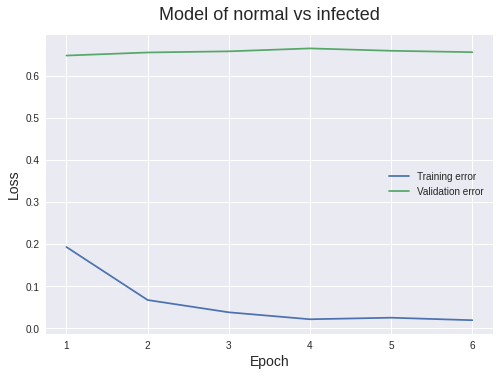

 10%|█         | 1/10 [00:03<00:32,  3.57s/it]

Epoch: 1/10 -  Time:2021-03-21 03:43:21.711327 Training Loss: 1.243 -  Validation Loss: 0.691 -  Validation Accuracy: 0.396 - 
F1 score: 0.542 Confusion Matrix: tensor([[ 15, 227],
        [  3, 136]])
Validation loss decreased (inf --> 0.690862).  Saving model ...


 20%|██        | 2/10 [00:07<00:28,  3.56s/it]

Epoch: 2/10 -  Time:2021-03-21 03:43:25.264649 Training Loss: 0.615 -  Validation Loss: 0.688 -  Validation Accuracy: 0.371 - 
F1 score: 0.529 Confusion Matrix: tensor([[  6, 236],
        [  4, 135]])
Validation loss decreased (0.690862 --> 0.688176).  Saving model ...


 30%|███       | 3/10 [00:10<00:24,  3.56s/it]

Epoch: 3/10 -  Time:2021-03-21 03:43:28.840129 Training Loss: 0.548 -  Validation Loss: 0.692 -  Validation Accuracy: 0.389 - 
F1 score: 0.539 Confusion Matrix: tensor([[ 12, 230],
        [  3, 136]])
EarlyStopping counter: 1 out of 5


 40%|████      | 4/10 [00:14<00:21,  3.56s/it]

Epoch: 4/10 -  Time:2021-03-21 03:43:32.390993 Training Loss: 0.457 -  Validation Loss: 0.693 -  Validation Accuracy: 0.389 - 
F1 score: 0.540 Confusion Matrix: tensor([[ 11, 231],
        [  2, 137]])
EarlyStopping counter: 2 out of 5


 50%|█████     | 5/10 [00:17<00:17,  3.56s/it]

Epoch: 5/10 -  Time:2021-03-21 03:43:35.960518 Training Loss: 0.416 -  Validation Loss: 0.693 -  Validation Accuracy: 0.401 - 
F1 score: 0.546 Confusion Matrix: tensor([[ 16, 226],
        [  2, 137]])
EarlyStopping counter: 3 out of 5


 60%|██████    | 6/10 [00:21<00:14,  3.57s/it]

Epoch: 6/10 -  Time:2021-03-21 03:43:39.533228 Training Loss: 0.374 -  Validation Loss: 0.693 -  Validation Accuracy: 0.406 - 
F1 score: 0.548 Confusion Matrix: tensor([[ 18, 224],
        [  2, 137]])
EarlyStopping counter: 4 out of 5


 60%|██████    | 6/10 [00:24<00:16,  4.15s/it]

Epoch: 7/10 -  Time:2021-03-21 03:43:43.088198 Training Loss: 0.349 -  Validation Loss: 0.691 -  Validation Accuracy: 0.404 - 
F1 score: 0.543 Confusion Matrix: tensor([[ 19, 223],
        [  4, 135]])
EarlyStopping counter: 5 out of 5
Early stopping


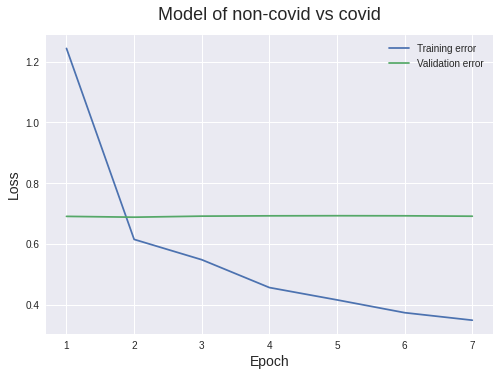

In [20]:
EPOCH = 10
LR = 0.0001
DEVICE = torch.device("cuda")

### Train from scratch ###
# 1st Classifer (Normal and Infected)
normal_model = train(EPOCH, labels_dict, train_loader, val_loader, model, LR, DEVICE, modelType = "normal" )

# 2nd Classifier (Covid and Non-covid)
infected_model = train(EPOCH, labels_dict_infected , train_loader2, val_loader2, model, LR, DEVICE, modelType = "infected")

In [24]:
### Loading Of Model ###
# Load normal model
normal_model = load_model('group20-normal-final.pt')
# # Retrain loaded Model
# normal_model = train(EPOCH, labels_dict, train_loader, val_loader, normal_model, LR, DEVICE, modelType = "normal" )

# Load infected model
infected_model = load_model('group20-infected-final.pt')
# # Retrain loaded model
# infected_model = train(EPOCH, labels_dict_infected , train_loader2, val_loader2, model, LR, DEVICE, modelType = "infected")

{'normal_normal': 8, 'normal_covid': 1, 'normal_noncovid': 0, 'covid_normal': 0, 'covid_covid': 1, 'covid_noncovid': 3, 'noncovid_normal': 0, 'noncovid_covid': 6, 'noncovid_noncovid': 6}


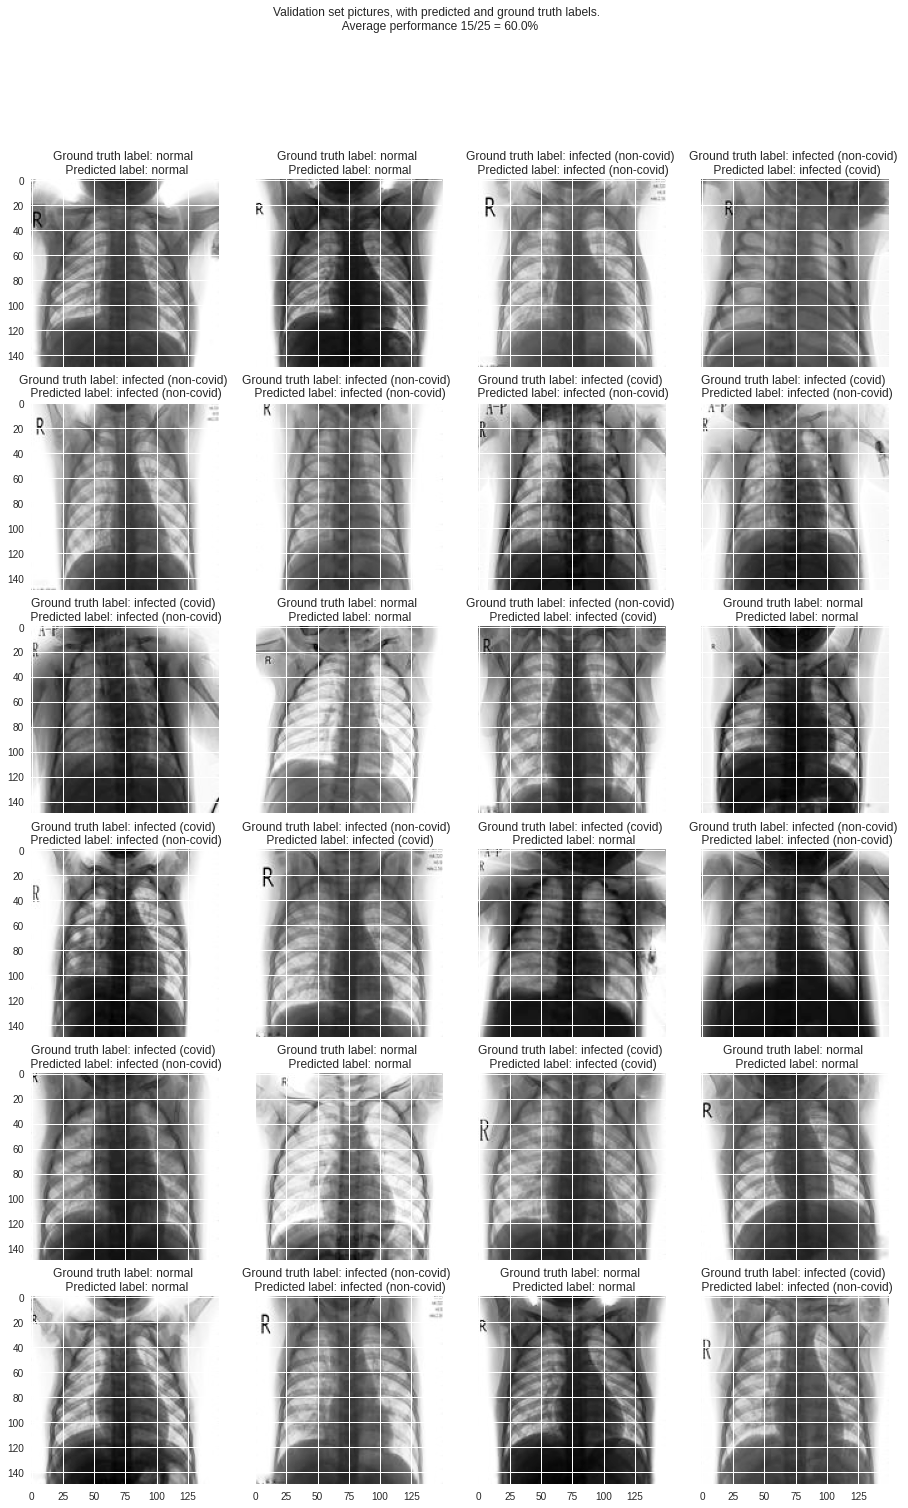

Testing Accuracy: 0.400
F1 Score: 0.747


In [30]:
# Test model
accuracy, F1_score, confusion_matrix = test_model(normal_model, infected_model, test_loader, DEVICE)

In [31]:
# Show confusion matrix
confusion_matrix

,,true normal,true covid,true noncovid
,predicted normal,8,1,0
,predicted covid,0,1,3
,predicted noncovid,0,6,6


# BONUS: Data Augmentation

## New dataset

In [13]:
# To augment the 0th class for 1st classifier
# Dataset object for training and validation
class Lung_Dataset_w_augmentation1(Dataset):
    def __init__(self, label, group, dataset_paths):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """

        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected) or (covid and non-covid)
        self.classes = label
        
        # The dataset consists only of test images
        self.group = group

        # Path to images for different parts of the dataset
        self.dataset_paths = dataset_paths
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {}
        for key, listofpaths in dataset_paths.items(): # e.g. {'train_normal': [train_normal],  'train_infected': [train_infected_covid, train_infected_noncovid]}
            for path in listofpaths:
                num = count_from_dir(path)
                if key not in self.dataset_numbers:
                    self.dataset_numbers[key] = {path: num}
                else:
                    olddict = self.dataset_numbers[key]
                    olddict[path] = num
                    self.dataset_numbers[key] = olddict
    

    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """

        # Generate description
        msg = "This is the {} dataset of the Lung Dataset".format(self.group)
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        for key, listofpaths in self.dataset_paths.items():
            length = 0
            for path in listofpaths:
                length += self.dataset_numbers[key][path]
            msg += "- {} has a total of {} images.\n".format(key, length)
        print(msg)
    

    def open_img(self, group_val, class_val, index_val, flip=False):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.group, err_msg
        
        err_msg = "Error - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid')."
        assert class_val in self.classes.values(), err_msg
        
        max_val = sum(self.dataset_numbers['{}_{}'.format(group_val, class_val)].values())
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images-1."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        for path in self.dataset_paths['{}_{}'.format(group_val, class_val)]:
            length = self.dataset_numbers['{}_{}'.format(group_val, class_val)][path]
            if index_val >= length: 
                index_val -= length
                continue
            else: 
                path_to_file = '{}/{}.jpg'.format(path, index_val)
                with open(path_to_file, 'rb') as f:
                    if flip:
                        im = np.asarray(Image.open(f))/255
                        im = np.fliplr(im) #flip vertically
                    else: 
                        im = np.asarray(Image.open(f))/255
                f.close()
                return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """

        # Open and display image
        im = self.open_img(group_val, class_val, index_val)
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        total = 0
        for key, val in self.dataset_numbers.items():
            for num in val.values():
                total += num
        
        for k,v in self.dataset_numbers[f'{self.group}_{self.classes[0]}'].items():
            total += v
        return total

    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
    
        # Get length of each class
        itemtotal = {}
        for key, val in self.classes.items():
            itemtotal[key] = sum(self.dataset_numbers['{}_{}'.format(self.group, val)].values())
            
        # Get total of ORIGINAL dataset
        total = 0
        for key, val in self.dataset_numbers.items():
            for num in val.values():
                total += num

        # Get item special method
        first_val = itemtotal[0]
        
        # belongs to the original dataset
        if index <= total-1:
            if index < first_val:
                class_val = self.classes[0]
                label = torch.Tensor([1, 0])
            else:
                class_val = self.classes[1]
                index = index - first_val
                label = torch.Tensor([0, 1])
            im = self.open_img(self.group, class_val, index)
            im = transforms.functional.to_tensor(np.array(im)).float()
        else:
            #augmented data of class 1,0
            class_val = self.classes[0]
            label = torch.Tensor([1, 0])
            im = self.open_img(self.group, class_val, index-total, flip=True)
            im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [20]:
# To augment the 1st class for 2nd classifier
# Dataset object for training and validation
class Lung_Dataset_w_augmentation2(Dataset):
    def __init__(self, label, group, dataset_paths):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """

        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected) or (covid and non-covid)
        self.classes = label
        
        # The dataset consists only of test images
        self.group = group

        # Path to images for different parts of the dataset
        self.dataset_paths = dataset_paths
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {}
        for key, listofpaths in dataset_paths.items(): # e.g. {'train_normal': [train_normal],  'train_infected': [train_infected_covid, train_infected_noncovid]}
            for path in listofpaths:
                num = count_from_dir(path)
                if key not in self.dataset_numbers:
                    self.dataset_numbers[key] = {path: num}
                else:
                    olddict = self.dataset_numbers[key]
                    olddict[path] = num
                    self.dataset_numbers[key] = olddict
    

    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """

        # Generate description
        msg = "This is the {} dataset of the Lung Dataset".format(self.group)
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        for key, listofpaths in self.dataset_paths.items():
            length = 0
            for path in listofpaths:
                length += self.dataset_numbers[key][path]
            msg += "- {} has a total of {} images.\n".format(key, length)
        print(msg)
    

    def open_img(self, group_val, class_val, index_val, flip=False):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.group, err_msg
        
        err_msg = "Error - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid')."
        assert class_val in self.classes.values(), err_msg
        
        max_val = sum(self.dataset_numbers['{}_{}'.format(group_val, class_val)].values())
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images-1."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        for path in self.dataset_paths['{}_{}'.format(group_val, class_val)]:
            length = self.dataset_numbers['{}_{}'.format(group_val, class_val)][path]
            if index_val >= length: 
                index_val -= length
                continue
            else: 
                path_to_file = '{}/{}.jpg'.format(path, index_val)
                with open(path_to_file, 'rb') as f:
                    if flip:
                        im = np.asarray(Image.open(f))/255
                        im = np.fliplr(im) #flip vertically
                    else: 
                        im = np.asarray(Image.open(f))/255
                f.close()
                return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to ('normal' or 'infected') or ('covid' or 'non-covid').
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """

        # Open and display image
        im = self.open_img(group_val, class_val, index_val)
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        total = 0
        for key, val in self.dataset_numbers.items():
            for num in val.values():
                total += num
        
        for k,v in self.dataset_numbers[f'{self.group}_{self.classes[1]}'].items():
            total += v
        return total

    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
    
        # Get length of each class
        itemtotal = {}
        for key, val in self.classes.items():
            itemtotal[key] = sum(self.dataset_numbers['{}_{}'.format(self.group, val)].values())
            
        # Get total of ORIGINAL dataset
        total = 0
        for key, val in self.dataset_numbers.items():
            for num in val.values():
                total += num

        # Get item special method
        first_val = itemtotal[0]
        
        # belongs to the original dataset
        if index <= total-1:
            if index < first_val:
                class_val = self.classes[0]
                label = torch.Tensor([1, 0])
            else:
                class_val = self.classes[1]
                index = index - first_val
                label = torch.Tensor([0, 1])
            im = self.open_img(self.group, class_val, index)
            im = transforms.functional.to_tensor(np.array(im)).float()
        else:
            #augmented data of class 0,1
            class_val = self.classes[1]
            label = torch.Tensor([0, 1])
            im = self.open_img(self.group, class_val, index-total, flip=True)
            im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

## Load Dataset

In [21]:
# data augmentation to increase training data should only be done on TRAIN set

# 1st Classifier
print("1st Classifier")
print("\nTraining Dataset")
ld_train_w_augmentation = Lung_Dataset_w_augmentation1(labels_dict, "train", {"train_normal": [train_normal],  "train_infected": [train_infected_covid, train_infected_noncovid]})
ld_train_w_augmentation.describe()
print(len(ld_train_w_augmentation))

print("\nVal Dataset")
ld_val = Lung_Dataset(labels_dict, "val", {"val_normal": [val_normal],  "val_infected": [val_infected_covid, val_infected_noncovid]})
ld_val.describe()

# 2nd Classifier
print("\n2nd Classifier")
print("\nTraining Dataset")
ld_train2_w_augmentation = Lung_Dataset_w_augmentation2(labels_dict_infected, "train", {"train_non-covid": [train_infected_noncovid],  "train_covid": [train_infected_covid]})
ld_train2_w_augmentation.describe()
print(len(ld_train2_w_augmentation))

print("\nVal Dataset")
ld_val2 = Lung_Dataset(labels_dict_infected, "val", {"val_non-covid": [val_infected_noncovid],  "val_covid": [val_infected_covid]})
ld_val2.describe()

# Test Classifier
print("\nTest Dataset")
ld_test = Test_Lung_Dataset(labels_dict_test, "test", {"test_normal": [test_normal],  "test_infected": [test_infected_covid, test_infected_noncovid]})
ld_test.describe()

1st Classifier

Training Dataset
This is the train dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- train_normal has a total of 1341 images.
- train_infected has a total of 3875 images.

6557

Val Dataset
This is the val dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- val_normal has a total of 234 images.
- val_infected has a total of 381 images.


2nd Classifier

Training Dataset
This is the train dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- train_non-covid has a total of 2530 images.
- train_covid has a total of 1345 images.

5220

Val Dataset
This is the val dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
- val_non-covid has a total of 242 images.
- val_covid has a total of 139 images.


Test Dataset
This is the tes

In [23]:
# Batch size value to be used
bs_val = 64

# Dataloader from dataset (train-1st Classifier)
train_loader_w_augmentation = DataLoader(ld_train_w_augmentation, batch_size = bs_val, shuffle = True)
print(train_loader_w_augmentation)
print(len(train_loader_w_augmentation))

# # Dataloader from dataset (test-1st Classifier)
# test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
# print(test_loader)

# Dataloader from dataset (val-1st Classifier)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

# Dataloader from dataset (train-2nd Classifier)
train_loader2_w_augmentation = DataLoader(ld_train2_w_augmentation, batch_size = bs_val, shuffle = True)
print(train_loader2_w_augmentation)
print(len(train_loader2_w_augmentation))

# # Dataloader from dataset (test-2nd Classifier)
# test_loader2 = DataLoader(ld_test2, batch_size = bs_val, shuffle = True)
# print(test_loader2)

# Dataloader from dataset (val-2nd Classifier)
val_loader2 = DataLoader(ld_val2, batch_size = bs_val, shuffle = True)
print(val_loader2)

# Dataloader from dataset (test)
test_loader = DataLoader(ld_test, batch_size = 1, shuffle = True)
print(test_loader)

103
82


## Train model

 10%|█         | 1/10 [00:08<01:17,  8.63s/it]

Epoch: 1/10 -  Time:2021-03-21 07:59:02.311727 Training Loss: 0.304 -  Validation Loss: 0.631 -  Validation Accuracy: 0.845 - 
F1 score: 0.884 Confusion Matrix: tensor([[154,  80],
        [ 16, 365]])
Validation loss decreased (inf --> 0.631237).  Saving model ...


 20%|██        | 2/10 [00:14<01:02,  7.84s/it]

Epoch: 2/10 -  Time:2021-03-21 07:59:08.322384 Training Loss: 0.070 -  Validation Loss: 0.634 -  Validation Accuracy: 0.846 - 
F1 score: 0.881 Confusion Matrix: tensor([[168,  66],
        [ 29, 352]])
EarlyStopping counter: 1 out of 10


 30%|███       | 3/10 [00:20<00:50,  7.28s/it]

Epoch: 3/10 -  Time:2021-03-21 07:59:14.293438 Training Loss: 0.043 -  Validation Loss: 0.633 -  Validation Accuracy: 0.789 - 
F1 score: 0.851 Confusion Matrix: tensor([[114, 120],
        [ 10, 371]])
EarlyStopping counter: 2 out of 10


 40%|████      | 4/10 [00:26<00:41,  6.89s/it]

Epoch: 4/10 -  Time:2021-03-21 07:59:20.276277 Training Loss: 0.028 -  Validation Loss: 0.634 -  Validation Accuracy: 0.802 - 
F1 score: 0.858 Confusion Matrix: tensor([[132, 102],
        [ 18, 363]])
EarlyStopping counter: 3 out of 10


 50%|█████     | 5/10 [00:32<00:33,  6.61s/it]

Epoch: 5/10 -  Time:2021-03-21 07:59:26.236317 Training Loss: 0.020 -  Validation Loss: 0.633 -  Validation Accuracy: 0.805 - 
F1 score: 0.857 Confusion Matrix: tensor([[139,  95],
        [ 24, 357]])
EarlyStopping counter: 4 out of 10


 60%|██████    | 6/10 [00:38<00:25,  6.44s/it]

Epoch: 6/10 -  Time:2021-03-21 07:59:32.251754 Training Loss: 0.016 -  Validation Loss: 0.629 -  Validation Accuracy: 0.810 - 
F1 score: 0.859 Confusion Matrix: tensor([[142,  92],
        [ 25, 356]])
Validation loss decreased (0.631237 --> 0.628908).  Saving model ...


 70%|███████   | 7/10 [00:44<00:18,  6.30s/it]

Epoch: 7/10 -  Time:2021-03-21 07:59:38.248100 Training Loss: 0.008 -  Validation Loss: 0.627 -  Validation Accuracy: 0.795 - 
F1 score: 0.850 Confusion Matrix: tensor([[129, 105],
        [ 22, 359]])
Validation loss decreased (0.628908 --> 0.627004).  Saving model ...


 80%|████████  | 8/10 [00:50<00:12,  6.23s/it]

Epoch: 8/10 -  Time:2021-03-21 07:59:44.308069 Training Loss: 0.005 -  Validation Loss: 0.623 -  Validation Accuracy: 0.776 - 
F1 score: 0.841 Confusion Matrix: tensor([[113, 121],
        [ 17, 364]])
Validation loss decreased (0.627004 --> 0.622691).  Saving model ...


 90%|█████████ | 9/10 [00:56<00:06,  6.21s/it]

Epoch: 9/10 -  Time:2021-03-21 07:59:50.486515 Training Loss: 0.003 -  Validation Loss: 0.624 -  Validation Accuracy: 0.790 - 
F1 score: 0.846 Confusion Matrix: tensor([[120, 114],
        [ 18, 363]])
EarlyStopping counter: 1 out of 10


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]

Epoch: 10/10 -  Time:2021-03-21 07:59:56.544922 Training Loss: 0.002 -  Validation Loss: 0.625 -  Validation Accuracy: 0.781 - 
F1 score: 0.842 Confusion Matrix: tensor([[114, 120],
        [ 17, 364]])
EarlyStopping counter: 2 out of 10


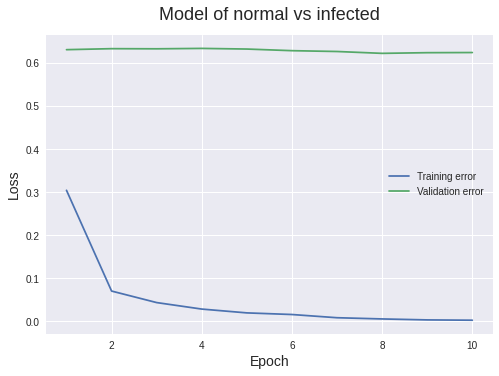

 10%|█         | 1/10 [00:04<00:42,  4.68s/it]

Epoch: 1/10 -  Time:2021-03-21 08:00:01.382576 Training Loss: 0.987 -  Validation Loss: 0.736 -  Validation Accuracy: 0.378 - 
F1 score: 0.534 Confusion Matrix: tensor([[  8, 234],
        [  3, 136]])
Validation loss decreased (inf --> 0.736329).  Saving model ...


 20%|██        | 2/10 [00:09<00:37,  4.68s/it]

Epoch: 2/10 -  Time:2021-03-21 08:00:06.075672 Training Loss: 0.531 -  Validation Loss: 0.746 -  Validation Accuracy: 0.383 - 
F1 score: 0.538 Confusion Matrix: tensor([[  9, 233],
        [  2, 137]])
EarlyStopping counter: 1 out of 10


 30%|███       | 3/10 [00:14<00:32,  4.67s/it]

Epoch: 3/10 -  Time:2021-03-21 08:00:10.718812 Training Loss: 0.462 -  Validation Loss: 0.717 -  Validation Accuracy: 0.407 - 
F1 score: 0.543 Confusion Matrix: tensor([[ 21, 221],
        [  5, 134]])
Validation loss decreased (0.736329 --> 0.716795).  Saving model ...


 40%|████      | 4/10 [00:18<00:27,  4.66s/it]

Epoch: 4/10 -  Time:2021-03-21 08:00:15.370365 Training Loss: 0.570 -  Validation Loss: 0.729 -  Validation Accuracy: 0.407 - 
F1 score: 0.543 Confusion Matrix: tensor([[ 21, 221],
        [  5, 134]])
EarlyStopping counter: 1 out of 10


 50%|█████     | 5/10 [00:23<00:23,  4.67s/it]

Epoch: 5/10 -  Time:2021-03-21 08:00:20.070554 Training Loss: 0.366 -  Validation Loss: 0.745 -  Validation Accuracy: 0.377 - 
F1 score: 0.538 Confusion Matrix: tensor([[  6, 236],
        [  1, 138]])
EarlyStopping counter: 2 out of 10


 60%|██████    | 6/10 [00:27<00:18,  4.66s/it]

Epoch: 6/10 -  Time:2021-03-21 08:00:24.702774 Training Loss: 0.313 -  Validation Loss: 0.740 -  Validation Accuracy: 0.370 - 
F1 score: 0.535 Confusion Matrix: tensor([[  3, 239],
        [  1, 138]])
EarlyStopping counter: 3 out of 10


 70%|███████   | 7/10 [00:32<00:13,  4.65s/it]

Epoch: 7/10 -  Time:2021-03-21 08:00:29.341888 Training Loss: 0.289 -  Validation Loss: 0.728 -  Validation Accuracy: 0.370 - 
F1 score: 0.533 Confusion Matrix: tensor([[  4, 238],
        [  2, 137]])
EarlyStopping counter: 4 out of 10


 80%|████████  | 8/10 [00:37<00:09,  4.67s/it]

Epoch: 8/10 -  Time:2021-03-21 08:00:34.029593 Training Loss: 0.273 -  Validation Loss: 0.712 -  Validation Accuracy: 0.378 - 
F1 score: 0.533 Confusion Matrix: tensor([[  9, 233],
        [  4, 135]])
Validation loss decreased (0.716795 --> 0.712039).  Saving model ...


 90%|█████████ | 9/10 [00:42<00:04,  4.68s/it]

Epoch: 9/10 -  Time:2021-03-21 08:00:38.742401 Training Loss: 0.211 -  Validation Loss: 0.715 -  Validation Accuracy: 0.373 - 
F1 score: 0.534 Confusion Matrix: tensor([[  5, 237],
        [  2, 137]])
EarlyStopping counter: 1 out of 10


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]

Epoch: 10/10 -  Time:2021-03-21 08:00:43.412392 Training Loss: 0.215 -  Validation Loss: 0.702 -  Validation Accuracy: 0.381 - 
F1 score: 0.537 Confusion Matrix: tensor([[  8, 234],
        [  2, 137]])
Validation loss decreased (0.712039 --> 0.702500).  Saving model ...


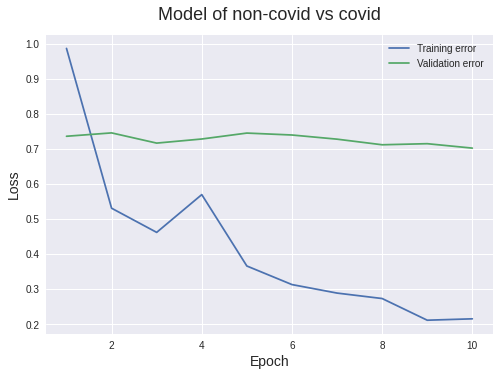

In [24]:
EPOCH = 10
LR = 0.0001
DEVICE = torch.device("cuda")

# 1st Classifer (Normal and Infected)
normal_model = train(EPOCH, labels_dict, train_loader_w_augmentation, val_loader, model, LR, DEVICE, modelType = "normal(aug)",patience=10 )

# 2nd Classifier (Covid and Non-covid)
infected_model = train(EPOCH, labels_dict_infected , train_loader2_w_augmentation, val_loader2, model, LR, DEVICE, modelType = "infected(aug)",patience=10)

In [25]:
### Loading Of Model ###
# Load normal model
normal_model = load_model('group20-normal(aug)-final.pt')

# # Load infected model
infected_model = load_model('group20-infected(aug)-final.pt')

{'normal_normal': 8, 'normal_covid': 0, 'normal_noncovid': 0, 'covid_normal': 0, 'covid_covid': 8, 'covid_noncovid': 8, 'noncovid_normal': 0, 'noncovid_covid': 0, 'noncovid_noncovid': 1}


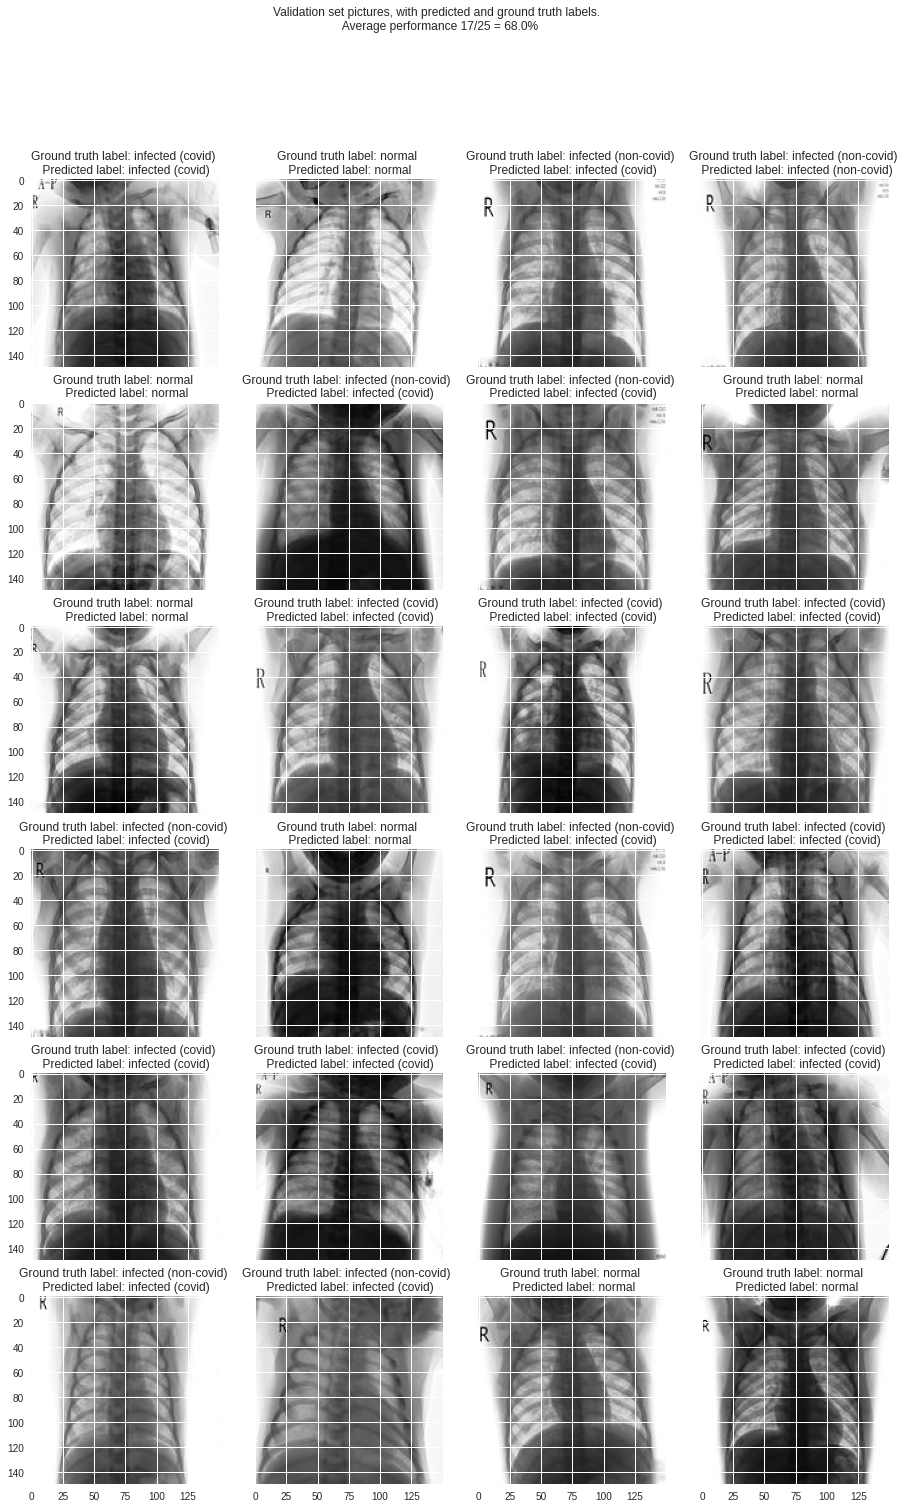

Testing Accuracy: 0.440
F1 Score: 0.810


In [26]:
# Test model
accuracy, F1_score, confusion_matrix = test_model(normal_model, infected_model, test_loader, DEVICE)

In [27]:
confusion_matrix

,,true normal,true covid,true noncovid
,predicted normal,8,0,0
,predicted covid,0,8,8
,predicted noncovid,0,0,1
